In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
from google.colab import files
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import resnet_v2

# Validasi dengan Augmentasi Proses

In [ ]:
# Data augmentation untuk training
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.1,
    brightness_range=[0.95, 1.05],
    horizontal_flip=False,
    fill_mode='nearest'
)

# Data preprocessing untuk validation dan test tanpa augmentasi
validation_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [ ]:
# Generator untuk data train
train_generator = train_datagen.flow_from_directory(
    '/content/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Generator untuk data validation
validation_generator = validation_datagen.flow_from_directory(
    '/content/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Generator untuk data test
test_generator = test_datagen.flow_from_directory(
    '/content/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 592 images belonging to 4 classes.
Found 198 images belonging to 4 classes.
Found 200 images belonging to 4 classes.


# **VGG16**

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Membekukan layer-layer VGG16 agar tidak dilatih
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Membangun model baru di atas base model VGG16
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Kompilasi model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Menampilkan summary model
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,788,868 (56.42 MB)

 Trainable params: 7,153,604 (27.29 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_vgg16.keras', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

In [ ]:
# Pelatihan Model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.2693 - loss: 1.4992 - val_accuracy: 0.2424 - val_loss: 1.3909 - learning_rate: 1.0000e-04
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 567ms/step - accuracy: 0.2813 - loss: 1.4090 - val_accuracy: 0.3283 - val_loss: 1.3514 - learning_rate: 1.0000e-04
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 587ms/step - accuracy: 0.3086 - loss: 1.3766 - val_accuracy: 0.4394 - val_loss: 1.3080 - learning_rate: 1.0000e-04
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 625ms/step - accuracy: 0.3197 - loss: 1.3363 - val_accuracy: 0.4343 - val_loss: 1.2625 - learning_rate: 1.0000e-04
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 601ms/step - accuracy: 0.4278 - loss: 1.2479 - val_accuracy: 0.4899 - val_loss: 1.2515 - learning_rate: 1.0000e-04
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 579ms/step - accuracy: 0.4326 - loss: 1.2552 - val_accuracy: 0.5000 - val_loss: 1.2239 - learning_rate: 1.0000e-04
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 606ms/step - accura

In [ ]:
# Evaluasi Model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7333 - loss: 0.7594
Test Accuracy: 69.50%


## Visualisasi hasil pelatihan

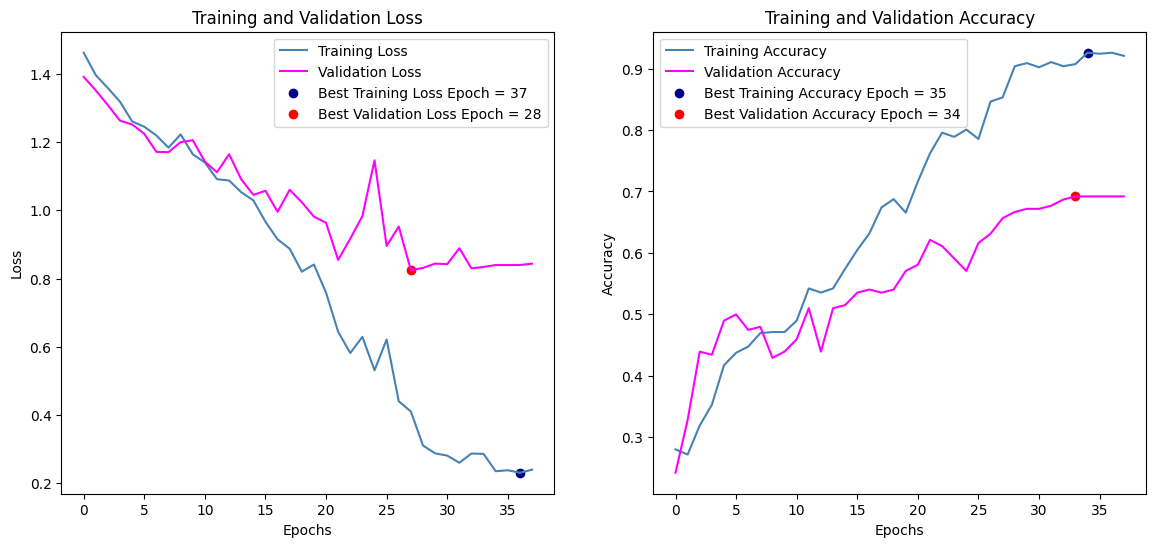

In [ ]:
# Mencari epoch dengan nilai terbaik
best_train_loss_epoch = np.argmin(history.history['loss'])  # Epoch dengan loss training terbaik
best_val_loss_epoch = np.argmin(history.history['val_loss'])  # Epoch dengan loss validasi terbaik
best_train_acc_epoch = np.argmax(history.history['accuracy'])  # Epoch dengan akurasi training terbaik
best_val_acc_epoch = np.argmax(history.history['val_accuracy'])  # Epoch dengan akurasi validasi terbaik

# Plot loss dan akurasi pada dua subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Training dan Validation Loss
ax1.plot(history.history['loss'], label='Training Loss', color='steelblue')  # Grafik loss training
ax1.plot(history.history['val_loss'], label='Validation Loss', color='magenta')  # Grafik loss validasi

# Titik pada epoch dengan Loss terbaik
ax1.scatter(best_train_loss_epoch, history.history['loss'][best_train_loss_epoch],
            label=f'Best Training Loss Epoch = {best_train_loss_epoch + 1}', color='darkblue')  # Titik terbaik training
ax1.scatter(best_val_loss_epoch, history.history['val_loss'][best_val_loss_epoch],
            label=f'Best Validation Loss Epoch = {best_val_loss_epoch + 1}', color='red')  # Titik terbaik validasi

ax1.set_title('Training and Validation Loss')  # Judul subplot
ax1.set_xlabel('Epochs')  # Label sumbu X
ax1.set_ylabel('Loss')  # Label sumbu Y
ax1.legend()  # Menampilkan legenda

# Subplot 2: Training dan Validation Accuracy
ax2.plot(history.history['accuracy'], label='Training Accuracy', color='steelblue')  # Grafik akurasi training
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', color='magenta')  # Grafik akurasi validasi

# Titik pada epoch dengan Accuracy terbaik
ax2.scatter(best_train_acc_epoch, history.history['accuracy'][best_train_acc_epoch],
            label=f'Best Training Accuracy Epoch = {best_train_acc_epoch + 1}', color='darkblue')  # Titik terbaik training
ax2.scatter(best_val_acc_epoch, history.history['val_accuracy'][best_val_acc_epoch],
            label=f'Best Validation Accuracy Epoch = {best_val_acc_epoch + 1}', color='red')  # Titik terbaik validasi

ax2.set_title('Training and Validation Accuracy')  # Judul subplot
ax2.set_xlabel('Epochs')  # Label sumbu X
ax2.set_ylabel('Accuracy')  # Label sumbu Y
ax2.legend()  # Menampilkan legenda

# Tampilkan grafik
plt.show()

## Confusion Matrix

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step


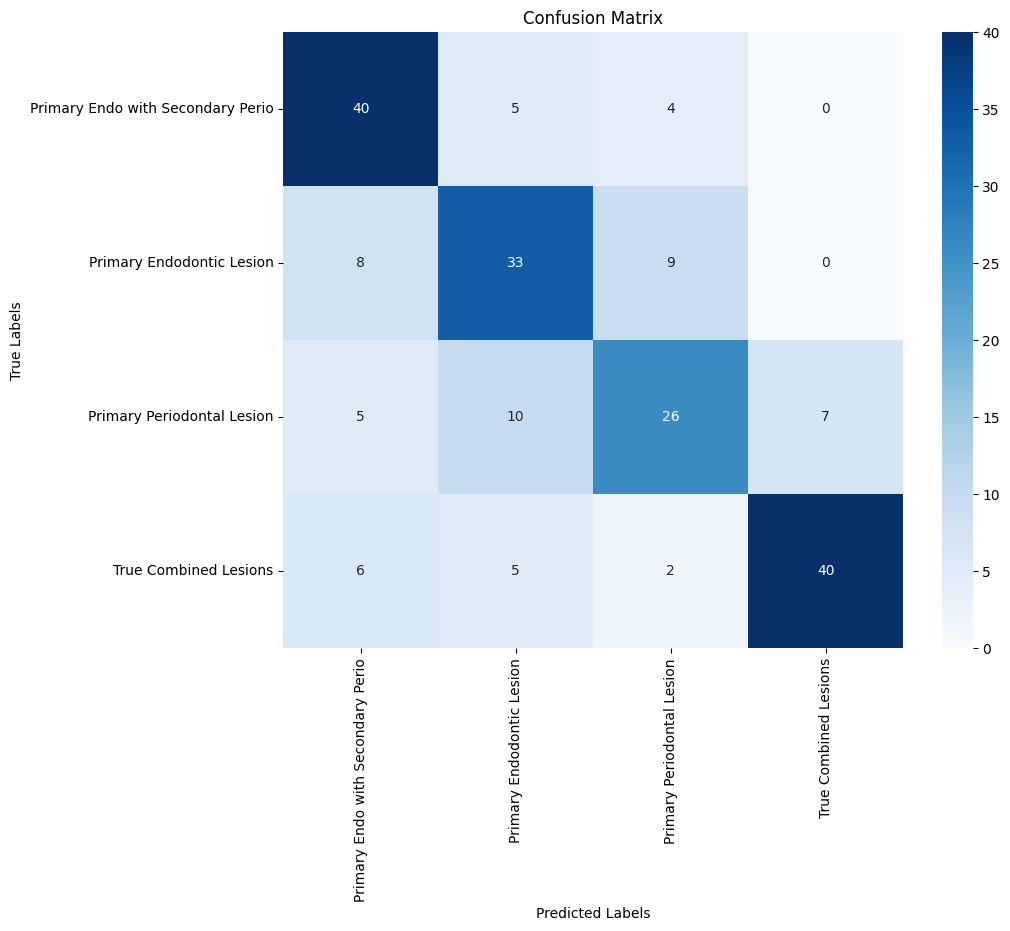

In [ ]:
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Menampilkan precision, recall, f1-score, dan accuracy
precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

Precision: 0.70
Recall: 0.69
F1-Score: 0.69
Accuracy: 0.69


In [ ]:
# Menghitung precision, recall, f1-score, dan accuracy
precision, recall, f1, support = precision_recall_fscore_support(true_classes, predicted_classes, average=None)
weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

# Menampilkan hasil per kelas
print("Per-Class Metrics:")
for i, label in enumerate(class_labels):
    print(f"Class '{label}':")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall: {recall[i]:.2f}")
    print(f"  F1-Score: {f1[i]:.2f}")
    print(f"  Support: {support[i]}")
    print()

# Menampilkan hasil rata-rata tertimbang dan akurasi
print("Overall Metrics:")
print(f"Weighted Precision: {weighted_precision:.2f}")
print(f"Weighted Recall: {weighted_recall:.2f}")
print(f"Weighted F1-Score: {weighted_f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

# Menampilkan hasil dalam bentuk tabel menggunakan pandas (opsional)
import pandas as pd

metrics_df = pd.DataFrame({
    'Class': class_labels,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

metrics_df.loc['Weighted Average'] = ['Overall', weighted_precision, weighted_recall, weighted_f1, sum(support)]

print("\nMetrics Table:")
print(metrics_df)


Per-Class Metrics:
Class 'Primary Endo with Secondary Perio':
  Precision: 0.68
  Recall: 0.82
  F1-Score: 0.74
  Support: 49

Class 'Primary Endodontic Lesion':
  Precision: 0.62
  Recall: 0.66
  F1-Score: 0.64
  Support: 50

Class 'Primary Periodontal Lesion':
  Precision: 0.63
  Recall: 0.54
  F1-Score: 0.58
  Support: 48

Class 'True Combined Lesions':
  Precision: 0.85
  Recall: 0.75
  F1-Score: 0.80
  Support: 53

Overall Metrics:
Weighted Precision: 0.70
Weighted Recall: 0.69
Weighted F1-Score: 0.69
Accuracy: 0.69

Metrics Table:
                                              Class  Precision    Recall  \
0                 Primary Endo with Secondary Perio   0.677966  0.816327   
1                         Primary Endodontic Lesion   0.622642  0.660000   
2                        Primary Periodontal Lesion   0.634146  0.541667   
3                             True Combined Lesions   0.851064  0.754717   
Weighted Average                            Overall   0.699489  0.695000   



## Implementasi

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
base_model = tf.keras.applications.ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Membekukan layer-layer tf.keras.applications.ResNet101 agar tidak dilatih
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Membangun model baru di atas base model tf.keras.applications.ResNet101
model2 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Kompilasi model
model2.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Menampilkan summary model
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet101 (Functional)               │ (None, 7, 7, 2048)          │      42,658,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,928,964 (163.76 MB)

 Trainable params: 1,325,508 (5.06 MB)

 Non-trainable params: 41,603,456 (158.70 MB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
]


In [ ]:
history2 = model2.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)


Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.2693 - loss: 1.6924 - val_accuracy: 0.2475 - val_loss: 1.4048 - learning_rate: 1.0000e-04
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 582ms/step - accuracy: 0.2385 - loss: 1.5073 - val_accuracy: 0.2677 - val_loss: 1.4029 - learning_rate: 1.0000e-04
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 477ms/step - accuracy: 0.2916 - loss: 1.4157 - val_accuracy: 0.2778 - val_loss: 1.4076 - learning_rate: 1.0000e-04
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 520ms/step - accuracy: 0.3237 - loss: 1.3614 - val_accuracy: 0.2828 - val_loss: 1.4005 - learning_rate: 1.0000e-04
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 548ms/step - accuracy: 0.2942 - loss: 1.3471 - val_accuracy: 0.2828 - val_loss: 1.4041 - learning_rate: 1.0000e-04
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 546ms/step - accuracy: 0.3337 - loss: 1.3266 - val_accuracy: 0.2626 - val_loss: 1.4036 - learning_rate: 1.0000e-04
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 589ms/step - accura

KeyboardInterrupt: 

# Resnet50v2

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import resnet_v2

# Parameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Preprocessing function from ResNetV2
preprocess_input = resnet_v2.preprocess_input

# ImageDataGenerator for train and validation
train_datagen2 = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen2 = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen2 = ImageDataGenerator(preprocessing_function=preprocess_input)


train_gen2 = train_datagen2.flow_from_directory(
    '/content/train',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen2 = val_datagen2.flow_from_directory(
    '/content/val',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen2 = test_datagen2.flow_from_directory(
    '/content/test',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 592 images belonging to 4 classes.
Found 198 images belonging to 4 classes.
Found 200 images belonging to 4 classes.


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load ResNet50V2 (alternatively, ResNet101V2 or ResNet152V2)
base_model = resnet_v2.ResNet50V2(
    weights='imagenet',          # Pretrained weights
    include_top=False,           # Exclude fully connected layers
    input_shape=(224, 224, 3)    # Input image size
)

# Freeze all layers except the last few
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Convert feature maps to a single vector
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

# Final model
model3 = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model3.summary()


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv  

 Total params: 23,835,588 (90.93 MB)

 Trainable params: 3,686,852 (14.06 MB)

 Non-trainable params: 20,148,736 (76.86 MB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
]


In [ ]:
# Train the model
history3 = model3.fit(
    train_gen2,
    validation_data=val_gen2,
    epochs=50,
    callbacks=callbacks
)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.2507 - loss: 1.7933 - val_accuracy: 0.3081 - val_loss: 1.6795 - learning_rate: 0.0010
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 414ms/step - accuracy: 0.3894 - loss: 1.3271 - val_accuracy: 0.3434 - val_loss: 1.7751 - learning_rate: 0.0010
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 488ms/step - accuracy: 0.3593 - loss: 1.3007 - val_accuracy: 0.4242 - val_loss: 1.7957 - learning_rate: 0.0010
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 542ms/step - accuracy: 0.4239 - loss: 1.2713 - val_accuracy: 0.3788 - val_loss: 1.6593 - learning_rate: 0.0010
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 474ms/step - accuracy: 0.4315 - loss: 1.2637 - val_accuracy: 0.3838 - val_loss: 2.5259 - learning_rate: 0.0010
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 544ms/step - accuracy: 0.4658 - loss: 1.1817 - val_accuracy: 0.4646 - val_loss: 1.6246 - learning_rate: 0.0010
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 498ms/step - accuracy: 0.5026 - loss: 1.1494 - val_acc

## Hasil evaluasi dan conf matrix

In [ ]:
# Evaluasi Model
test_loss, test_accuracy = model3.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 795ms/step - accuracy: 0.5633 - loss: 1.0992
Test Accuracy: 54.00%


7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 832ms/step


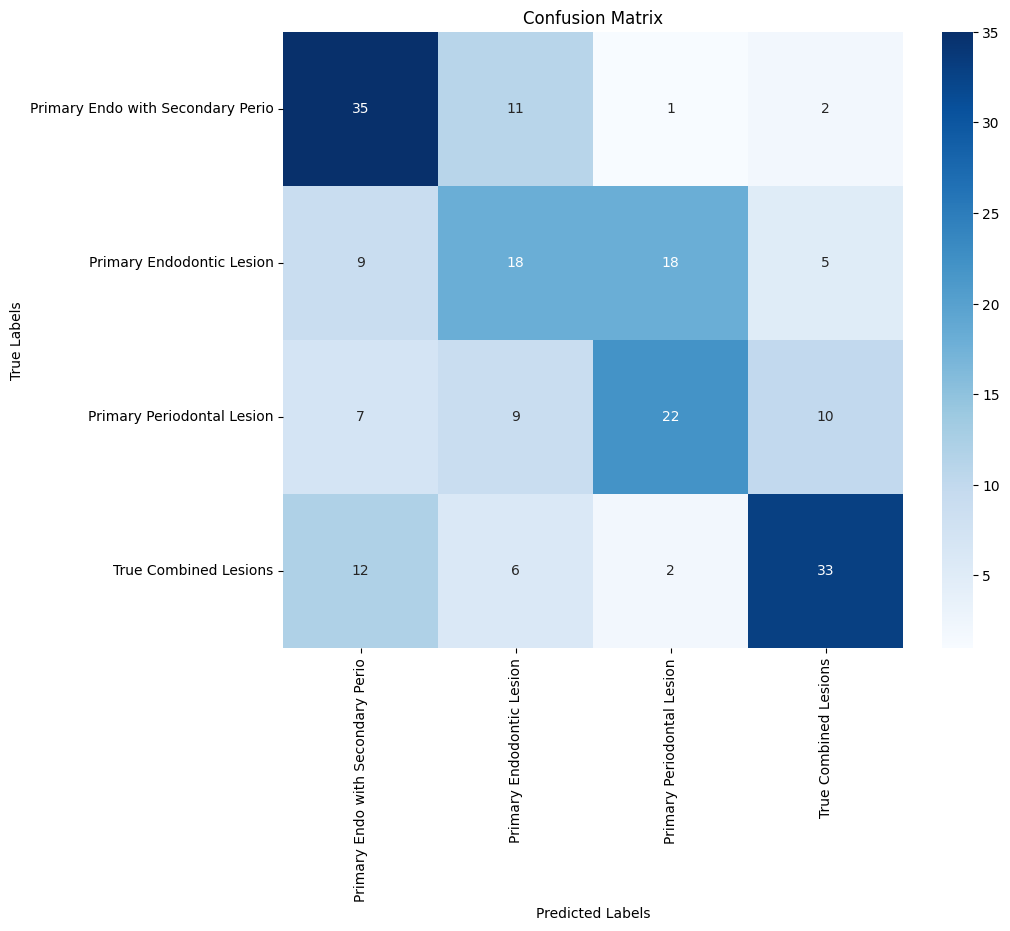

In [ ]:
test_generator.reset()
predictions = model3.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Resnet101v2

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load ResNet50V2 (alternatively, ResNet101V2 or ResNet152V2)
base_model = resnet_v2.ResNet101V2(
    weights='imagenet',          # Pretrained weights
    include_top=False,           # Exclude fully connected layers
    input_shape=(224, 224, 3)    # Input image size
)

# Freeze all layers except the last few
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Membangun model baru di atas base model VGG16
model4 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Kompilasi model
model4.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model4.summary()

171317808/171317808 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)             │ (None, 7, 7, 2048)          │      42,626,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,897,348 (163.64 MB)

 Trainable params: 1,325,508 (5.06 MB)

 Non-trainable params: 41,571,840 (158.58 MB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
]


In [ ]:
history4 = model4.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.2298 - loss: 1.7270 - val_accuracy: 0.3333 - val_loss: 1.3681 - learning_rate: 1.0000e-04
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 561ms/step - accuracy: 0.3250 - loss: 1.4792 - val_accuracy: 0.3333 - val_loss: 1.2778 - learning_rate: 1.0000e-04
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 578ms/step - accuracy: 0.4243 - loss: 1.3399 - val_accuracy: 0.3838 - val_loss: 1.2523 - learning_rate: 1.0000e-04
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 470ms/step - accuracy: 0.4291 - loss: 1.2379 - val_accuracy: 0.3838 - val_loss: 1.2320 - learning_rate: 1.0000e-04
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 496ms/step - accuracy: 0.4687 - loss: 1.2234 - val_accuracy: 0.4242 - val_loss: 1.1976 - learning_rate: 1.0000e-04
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 497ms/step - accuracy: 0.4140 - loss: 1.2093 - val_accuracy: 0.4848 - val_loss: 1.1731 - learning_rate: 1.0000e-04
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 575ms/step - accura

In [ ]:
# Evaluasi Model
test_loss, test_accuracy = model4.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 860ms/step - accuracy: 0.8173 - loss: 0.6134
Test Accuracy: 75.00%


7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step


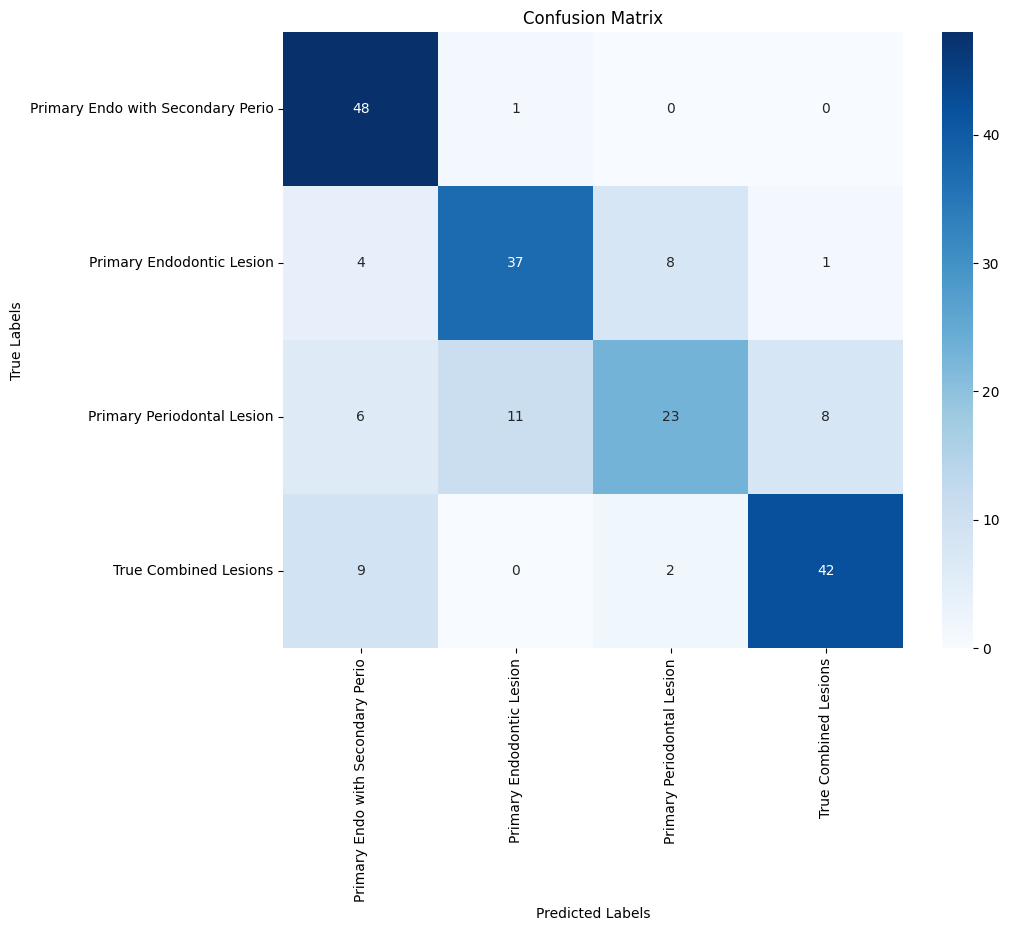

In [ ]:
test_generator.reset()
predictions = model4.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

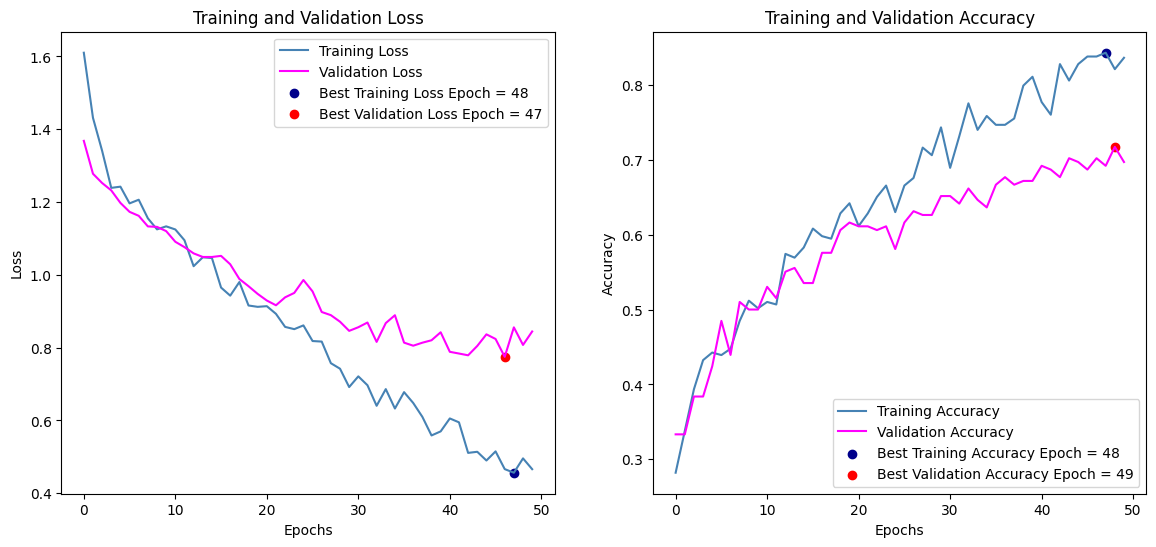

In [ ]:
# Mencari epoch dengan nilai terbaik
best_train_loss_epoch = np.argmin(history4.history['loss'])  # Epoch dengan loss training terbaik
best_val_loss_epoch = np.argmin(history4.history['val_loss'])  # Epoch dengan loss validasi terbaik
best_train_acc_epoch = np.argmax(history4.history['accuracy'])  # Epoch dengan akurasi training terbaik
best_val_acc_epoch = np.argmax(history4.history['val_accuracy'])  # Epoch dengan akurasi validasi terbaik

# Plot loss dan akurasi pada dua subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Training dan Validation Loss
ax1.plot(history4.history['loss'], label='Training Loss', color='steelblue')  # Grafik loss training
ax1.plot(history4.history['val_loss'], label='Validation Loss', color='magenta')  # Grafik loss validasi

# Titik pada epoch dengan Loss terbaik
ax1.scatter(best_train_loss_epoch, history4.history['loss'][best_train_loss_epoch],
            label=f'Best Training Loss Epoch = {best_train_loss_epoch + 1}', color='darkblue')  # Titik terbaik training
ax1.scatter(best_val_loss_epoch, history4.history['val_loss'][best_val_loss_epoch],
            label=f'Best Validation Loss Epoch = {best_val_loss_epoch + 1}', color='red')  # Titik terbaik validasi

ax1.set_title('Training and Validation Loss')  # Judul subplot
ax1.set_xlabel('Epochs')  # Label sumbu X
ax1.set_ylabel('Loss')  # Label sumbu Y
ax1.legend()  # Menampilkan legenda

# Subplot 2: Training dan Validation Accuracy
ax2.plot(history4.history['accuracy'], label='Training Accuracy', color='steelblue')  # Grafik akurasi training
ax2.plot(history4.history['val_accuracy'], label='Validation Accuracy', color='magenta')  # Grafik akurasi validasi

# Titik pada epoch dengan Accuracy terbaik
ax2.scatter(best_train_acc_epoch, history4.history['accuracy'][best_train_acc_epoch],
            label=f'Best Training Accuracy Epoch = {best_train_acc_epoch + 1}', color='darkblue')  # Titik terbaik training
ax2.scatter(best_val_acc_epoch, history4.history['val_accuracy'][best_val_acc_epoch],
            label=f'Best Validation Accuracy Epoch = {best_val_acc_epoch + 1}', color='red')  # Titik terbaik validasi

ax2.set_title('Training and Validation Accuracy')  # Judul subplot
ax2.set_xlabel('Epochs')  # Label sumbu X
ax2.set_ylabel('Accuracy')  # Label sumbu Y
ax2.legend()  # Menampilkan legenda

# Tampilkan grafik
plt.show()

In [ ]:
# Menampilkan precision, recall, f1-score, dan accuracy
precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

Precision: 0.75
Recall: 0.75
F1-Score: 0.74
Accuracy: 0.75


In [ ]:
# Menghitung precision, recall, f1-score, dan accuracy
precision, recall, f1, support = precision_recall_fscore_support(true_classes, predicted_classes, average=None)
weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

# Menampilkan hasil per kelas
print("Per-Class Metrics:")
for i, label in enumerate(class_labels):
    print(f"Class '{label}':")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall: {recall[i]:.2f}")
    print(f"  F1-Score: {f1[i]:.2f}")
    print(f"  Support: {support[i]}")
    print()

# Menampilkan hasil rata-rata tertimbang dan akurasi
print("Overall Metrics:")
print(f"Weighted Precision: {weighted_precision:.2f}")
print(f"Weighted Recall: {weighted_recall:.2f}")
print(f"Weighted F1-Score: {weighted_f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

# Menampilkan hasil dalam bentuk tabel menggunakan pandas (opsional)
import pandas as pd

metrics_df = pd.DataFrame({
    'Class': class_labels,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

metrics_df.loc['Weighted Average'] = ['Overall', weighted_precision, weighted_recall, weighted_f1, sum(support)]

print("\nMetrics Table:")
print(metrics_df)


Per-Class Metrics:
Class 'Primary Endo with Secondary Perio':
  Precision: 0.72
  Recall: 0.98
  F1-Score: 0.83
  Support: 49

Class 'Primary Endodontic Lesion':
  Precision: 0.76
  Recall: 0.74
  F1-Score: 0.75
  Support: 50

Class 'Primary Periodontal Lesion':
  Precision: 0.70
  Recall: 0.48
  F1-Score: 0.57
  Support: 48

Class 'True Combined Lesions':
  Precision: 0.82
  Recall: 0.79
  F1-Score: 0.81
  Support: 53

Overall Metrics:
Weighted Precision: 0.75
Weighted Recall: 0.75
Weighted F1-Score: 0.74
Accuracy: 0.75

Metrics Table:
                                              Class  Precision    Recall  \
0                 Primary Endo with Secondary Perio   0.716418  0.979592   
1                         Primary Endodontic Lesion   0.755102  0.740000   
2                        Primary Periodontal Lesion   0.696970  0.479167   
3                             True Combined Lesions   0.823529  0.792453   
Weighted Average                            Overall   0.749806  0.750000   



# Hyperparameter 2

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load ResNet50V2 (alternatively, ResNet101V2 or ResNet152V2)
base_model = resnet_v2.ResNet101V2(
    weights='imagenet',          # Pretrained weights
    include_top=False,           # Exclude fully connected layers
    input_shape=(224, 224, 3)    # Input image size
)

# Freeze all layers except the last few
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Membangun model baru di atas base model VGG16
model5 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Kompilasi model
model5.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model5.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)             │ (None, 7, 7, 2048)          │      42,626,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,922,884 (163.74 MB)

 Trainable params: 1,351,044 (5.15 MB)

 Non-trainable params: 41,571,840 (158.58 MB)

In [ ]:
history5 = model5.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 488ms/step - accuracy: 0.8150 - loss: 0.5047 - val_accuracy: 0.6869 - val_loss: 0.8597 - learning_rate: 2.5000e-05
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 514ms/step - accuracy: 0.8078 - loss: 0.4939 - val_accuracy: 0.6768 - val_loss: 0.8724 - learning_rate: 2.5000e-05
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 22s 609ms/step - accuracy: 0.8319 - loss: 0.4735 - val_accuracy: 0.6717 - val_loss: 0.8577 - learning_rate: 2.5000e-05
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 569ms/step - accuracy: 0.8305 - loss: 0.4716 - val_accuracy: 0.6616 - val_loss: 0.8625 - learning_rate: 2.5000e-05
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8243 - loss: 0.4331 - val_accuracy: 0.6818 - val_loss: 0.8628 - learning_rate: 2.5000e-05
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 33s 734ms/step - accuracy: 0.8446 - loss: 0.4382 - val_accuracy: 0.6818 - val_loss: 0.8538 - learning_rate: 2.5000e-05
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 34s 532ms/step - accuracy: 0.8470 

In [ ]:
# Evaluasi Model
test_loss, test_accuracy = model5.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 862ms/step - accuracy: 0.7649 - loss: 0.6327
Test Accuracy: 71.50%


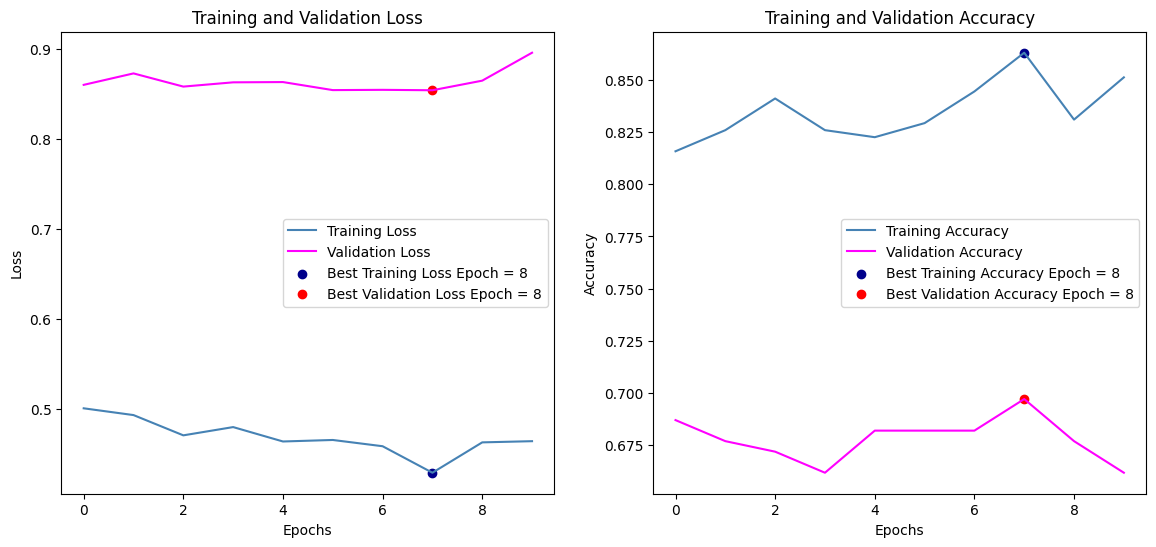

In [ ]:
# Mencari epoch dengan nilai terbaik
best_train_loss_epoch = np.argmin(history5.history['loss'])  # Epoch dengan loss training terbaik
best_val_loss_epoch = np.argmin(history5.history['val_loss'])  # Epoch dengan loss validasi terbaik
best_train_acc_epoch = np.argmax(history5.history['accuracy'])  # Epoch dengan akurasi training terbaik
best_val_acc_epoch = np.argmax(history5.history['val_accuracy'])  # Epoch dengan akurasi validasi terbaik

# Plot loss dan akurasi pada dua subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Training dan Validation Loss
ax1.plot(history5.history['loss'], label='Training Loss', color='steelblue')  # Grafik loss training
ax1.plot(history5.history['val_loss'], label='Validation Loss', color='magenta')  # Grafik loss validasi

# Titik pada epoch dengan Loss terbaik
ax1.scatter(best_train_loss_epoch, history5.history['loss'][best_train_loss_epoch],
            label=f'Best Training Loss Epoch = {best_train_loss_epoch + 1}', color='darkblue')  # Titik terbaik training
ax1.scatter(best_val_loss_epoch, history5.history['val_loss'][best_val_loss_epoch],
            label=f'Best Validation Loss Epoch = {best_val_loss_epoch + 1}', color='red')  # Titik terbaik validasi

ax1.set_title('Training and Validation Loss')  # Judul subplot
ax1.set_xlabel('Epochs')  # Label sumbu X
ax1.set_ylabel('Loss')  # Label sumbu Y
ax1.legend()  # Menampilkan legenda

# Subplot 2: Training dan Validation Accuracy
ax2.plot(history5.history['accuracy'], label='Training Accuracy', color='steelblue')  # Grafik akurasi training
ax2.plot(history5.history['val_accuracy'], label='Validation Accuracy', color='magenta')  # Grafik akurasi validasi

# Titik pada epoch dengan Accuracy terbaik
ax2.scatter(best_train_acc_epoch, history5.history['accuracy'][best_train_acc_epoch],
            label=f'Best Training Accuracy Epoch = {best_train_acc_epoch + 1}', color='darkblue')  # Titik terbaik training
ax2.scatter(best_val_acc_epoch, history5.history['val_accuracy'][best_val_acc_epoch],
            label=f'Best Validation Accuracy Epoch = {best_val_acc_epoch + 1}', color='red')  # Titik terbaik validasi

ax2.set_title('Training and Validation Accuracy')  # Judul subplot
ax2.set_xlabel('Epochs')  # Label sumbu X
ax2.set_ylabel('Accuracy')  # Label sumbu Y
ax2.legend()  # Menampilkan legenda

# Tampilkan grafik
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step


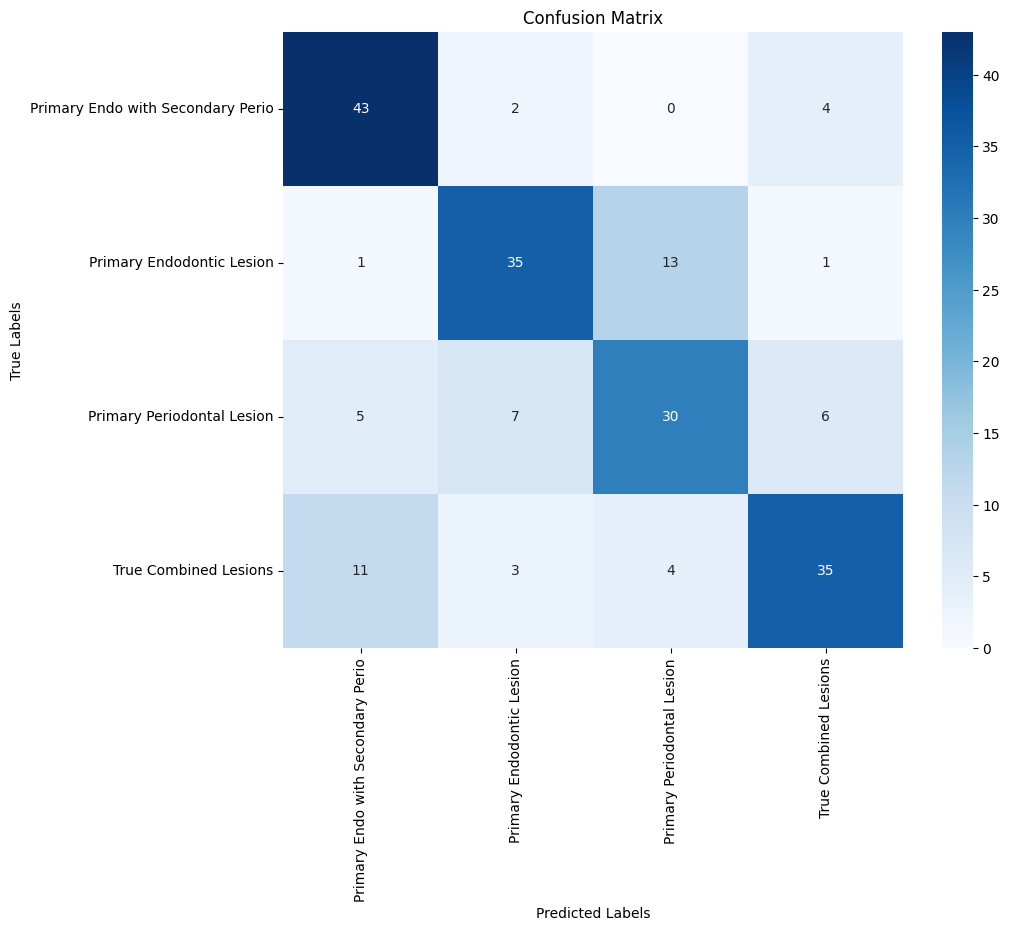

In [ ]:
test_generator.reset()
predictions = model5.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Menampilkan precision, recall, f1-score, dan accuracy
precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

Precision: 0.72
Recall: 0.71
F1-Score: 0.71
Accuracy: 0.71


# Hyperparameter 2_1

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load ResNet50V2 (alternatively, ResNet101V2 or ResNet152V2)
base_model = resnet_v2.ResNet101V2(
    weights='imagenet',          # Pretrained weights
    include_top=False,           # Exclude fully connected layers
    input_shape=(224, 224, 3)    # Input image size
)

# Freeze all layers except the last few
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Membangun model baru di atas base model VGG16
model6 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')
])

# Kompilasi model
model6.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model6.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)             │ (None, 7, 7, 2048)          │      42,626,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,741,828 (166.86 MB)

 Trainable params: 2,169,988 (8.28 MB)

 Non-trainable params: 41,571,840 (158.58 MB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
]


In [ ]:
history6 = model6.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.2713 - loss: 1.4698 - val_accuracy: 0.3990 - val_loss: 1.3548 - learning_rate: 1.0000e-04
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 697ms/step - accuracy: 0.4614 - loss: 1.1952 - val_accuracy: 0.4646 - val_loss: 1.1843 - learning_rate: 1.0000e-04
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 526ms/step - accuracy: 0.5319 - loss: 1.0962 - val_accuracy: 0.4545 - val_loss: 1.1735 - learning_rate: 1.0000e-04
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 22s 571ms/step - accuracy: 0.6087 - loss: 1.0102 - val_accuracy: 0.4899 - val_loss: 1.0749 - learning_rate: 1.0000e-04
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 495ms/step - accuracy: 0.6081 - loss: 0.9626 - val_accuracy: 0.5556 - val_loss: 1.0202 - learning_rate: 1.0000e-04
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 597ms/step - accuracy: 0.6644 - loss: 0.8909 - val_accuracy: 0.5808 - val_loss: 0.9961 - learning_rate: 1.0000e-04
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 594ms/step - accura

In [ ]:
# Evaluasi Model
test_loss, test_accuracy = model6.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 649ms/step - accuracy: 0.8480 - loss: 0.5951
Test Accuracy: 82.50%


7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step


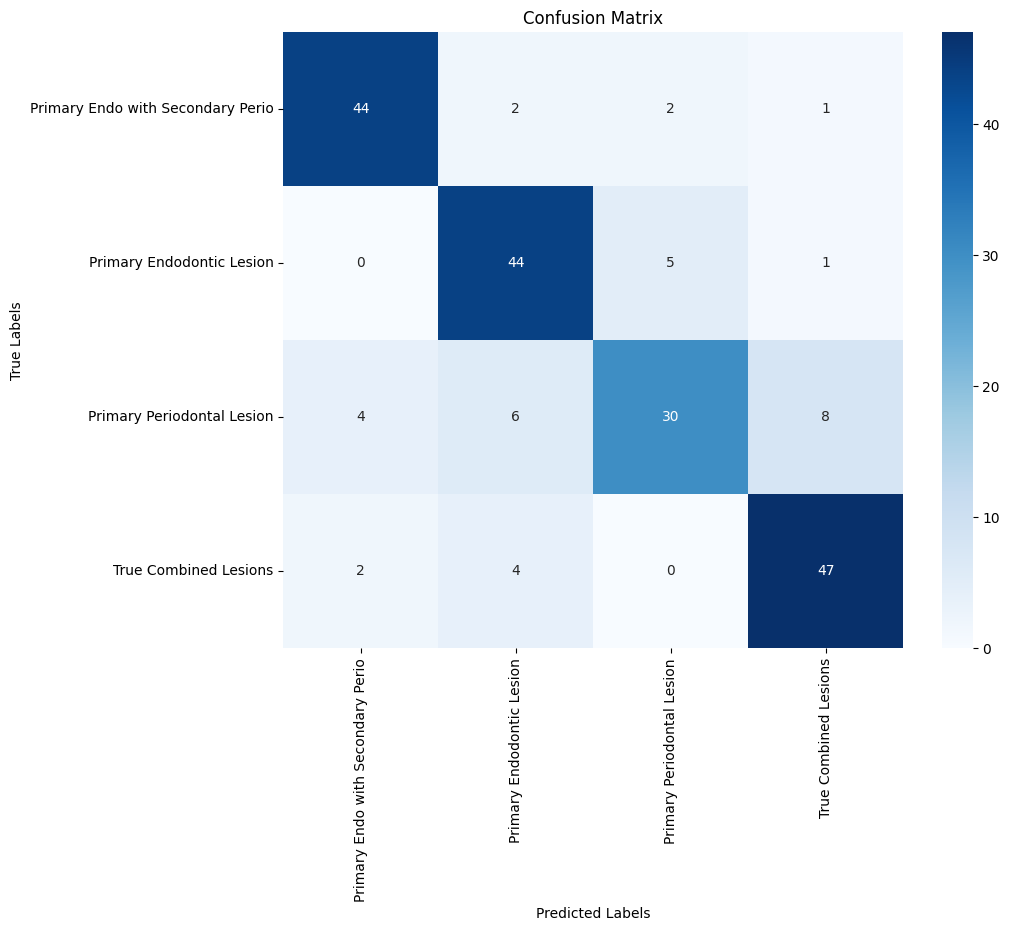

In [ ]:
test_generator.reset()
predictions = model6.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

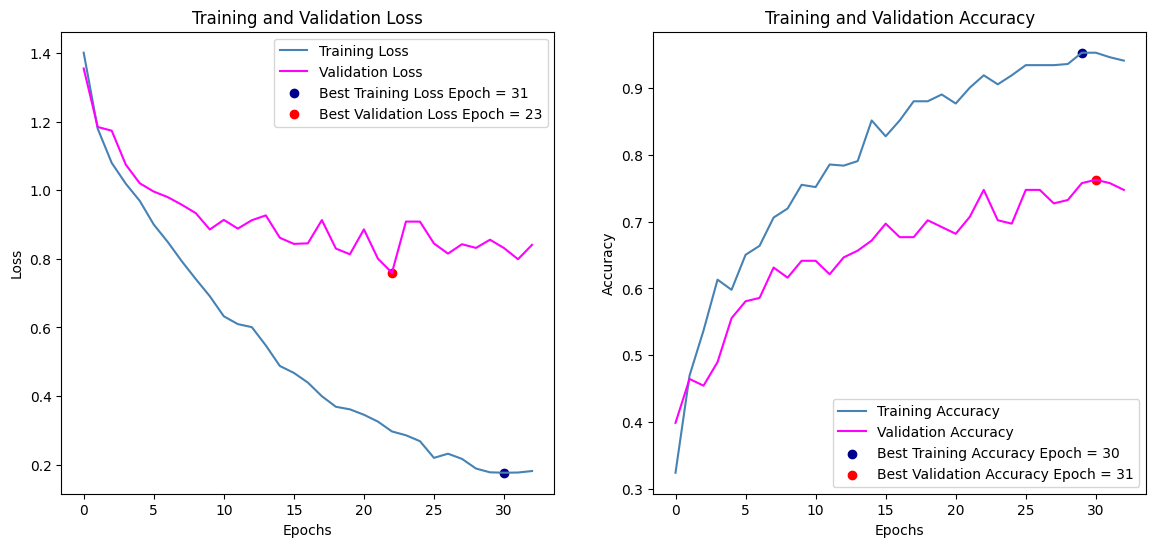

In [ ]:
# Mencari epoch dengan nilai terbaik
best_train_loss_epoch = np.argmin(history6.history['loss'])  # Epoch dengan loss training terbaik
best_val_loss_epoch = np.argmin(history6.history['val_loss'])  # Epoch dengan loss validasi terbaik
best_train_acc_epoch = np.argmax(history6.history['accuracy'])  # Epoch dengan akurasi training terbaik
best_val_acc_epoch = np.argmax(history6.history['val_accuracy'])  # Epoch dengan akurasi validasi terbaik

# Plot loss dan akurasi pada dua subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Training dan Validation Loss
ax1.plot(history6.history['loss'], label='Training Loss', color='steelblue')  # Grafik loss training
ax1.plot(history6.history['val_loss'], label='Validation Loss', color='magenta')  # Grafik loss validasi

# Titik pada epoch dengan Loss terbaik
ax1.scatter(best_train_loss_epoch, history6.history['loss'][best_train_loss_epoch],
            label=f'Best Training Loss Epoch = {best_train_loss_epoch + 1}', color='darkblue')  # Titik terbaik training
ax1.scatter(best_val_loss_epoch, history6.history['val_loss'][best_val_loss_epoch],
            label=f'Best Validation Loss Epoch = {best_val_loss_epoch + 1}', color='red')  # Titik terbaik validasi

ax1.set_title('Training and Validation Loss')  # Judul subplot
ax1.set_xlabel('Epochs')  # Label sumbu X
ax1.set_ylabel('Loss')  # Label sumbu Y
ax1.legend()  # Menampilkan legenda

# Subplot 2: Training dan Validation Accuracy
ax2.plot(history6.history['accuracy'], label='Training Accuracy', color='steelblue')  # Grafik akurasi training
ax2.plot(history6.history['val_accuracy'], label='Validation Accuracy', color='magenta')  # Grafik akurasi validasi

# Titik pada epoch dengan Accuracy terbaik
ax2.scatter(best_train_acc_epoch, history6.history['accuracy'][best_train_acc_epoch],
            label=f'Best Training Accuracy Epoch = {best_train_acc_epoch + 1}', color='darkblue')  # Titik terbaik training
ax2.scatter(best_val_acc_epoch, history6.history['val_accuracy'][best_val_acc_epoch],
            label=f'Best Validation Accuracy Epoch = {best_val_acc_epoch + 1}', color='red')  # Titik terbaik validasi

ax2.set_title('Training and Validation Accuracy')  # Judul subplot
ax2.set_xlabel('Epochs')  # Label sumbu X
ax2.set_ylabel('Accuracy')  # Label sumbu Y
ax2.legend()  # Menampilkan legenda

# Tampilkan grafik
plt.show()

In [ ]:
# Menampilkan precision, recall, f1-score, dan accuracy
precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

Precision: 0.83
Recall: 0.82
F1-Score: 0.82
Accuracy: 0.82


In [ ]:
# Menghitung precision, recall, f1-score, dan accuracy
precision, recall, f1, support = precision_recall_fscore_support(true_classes, predicted_classes, average=None)
weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

# Menampilkan hasil per kelas
print("Per-Class Metrics:")
for i, label in enumerate(class_labels):
    print(f"Class '{label}':")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall: {recall[i]:.2f}")
    print(f"  F1-Score: {f1[i]:.2f}")
    print(f"  Support: {support[i]}")
    print()

# Menampilkan hasil rata-rata tertimbang dan akurasi
print("Overall Metrics:")
print(f"Weighted Precision: {weighted_precision:.2f}")
print(f"Weighted Recall: {weighted_recall:.2f}")
print(f"Weighted F1-Score: {weighted_f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

# Menampilkan hasil dalam bentuk tabel menggunakan pandas (opsional)
import pandas as pd

metrics_df = pd.DataFrame({
    'Class': class_labels,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

metrics_df.loc['Weighted Average'] = ['Overall', weighted_precision, weighted_recall, weighted_f1, sum(support)]

print("\nMetrics Table:")
print(metrics_df)


Per-Class Metrics:
Class 'Primary Endo with Secondary Perio':
  Precision: 0.88
  Recall: 0.90
  F1-Score: 0.89
  Support: 49

Class 'Primary Endodontic Lesion':
  Precision: 0.79
  Recall: 0.88
  F1-Score: 0.83
  Support: 50

Class 'Primary Periodontal Lesion':
  Precision: 0.81
  Recall: 0.62
  F1-Score: 0.71
  Support: 48

Class 'True Combined Lesions':
  Precision: 0.82
  Recall: 0.89
  F1-Score: 0.85
  Support: 53

Overall Metrics:
Weighted Precision: 0.83
Weighted Recall: 0.82
Weighted F1-Score: 0.82
Accuracy: 0.82

Metrics Table:
                                              Class  Precision    Recall  \
0                 Primary Endo with Secondary Perio   0.880000  0.897959   
1                         Primary Endodontic Lesion   0.785714  0.880000   
2                        Primary Periodontal Lesion   0.810811  0.625000   
3                             True Combined Lesions   0.824561  0.886792   
Weighted Average                            Overall   0.825132  0.825000   



# HYPERPARAMETER 3_1


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load ResNet50V2 (alternatively, ResNet101V2 or ResNet152V2)
base_model = resnet_v2.ResNet101V2(
    weights='imagenet',          # Pretrained weights
    include_top=False,           # Exclude fully connected layers
    input_shape=(224, 224, 3)    # Input image size
)

# Freeze all layers except the last few
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Membangun model baru di atas base model VGG16
model7 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(4, activation='softmax')
])

# Kompilasi model
model7.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model7.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)             │ (None, 7, 7, 2048)          │      42,626,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,899,300 (163.65 MB)

 Trainable params: 1,327,460 (5.06 MB)

 Non-trainable params: 41,571,840 (158.58 MB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
]


In [ ]:
history7 = model7.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 583ms/step - accuracy: 0.5515 - loss: 1.0790 - val_accuracy: 0.5556 - val_loss: 1.1011 - learning_rate: 1.0000e-04
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 26s 842ms/step - accuracy: 0.5043 - loss: 1.0954 - val_accuracy: 0.5657 - val_loss: 1.0922 - learning_rate: 1.0000e-04
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 634ms/step - accuracy: 0.5806 - loss: 1.0145 - val_accuracy: 0.5253 - val_loss: 1.0974 - learning_rate: 1.0000e-04
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 595ms/step - accuracy: 0.5272 - loss: 1.0273 - val_accuracy: 0.5859 - val_loss: 1.0781 - learning_rate: 1.0000e-04
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 22s 723ms/step - accuracy: 0.5589 - loss: 1.0067 - val_accuracy: 0.5657 - val_loss: 1.0592 - learning_rate: 1.0000e-04
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 664ms/step - accuracy: 0.5829 - loss: 0.9895 - val_accuracy: 0.5808 - val_loss: 1.0430 - learning_rate: 1.0000e-04
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 493ms/step - acc

In [ ]:
# Evaluasi Model
test_loss, test_accuracy = model7.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 789ms/step - accuracy: 0.8023 - loss: 0.6604
Test Accuracy: 78.50%


7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step


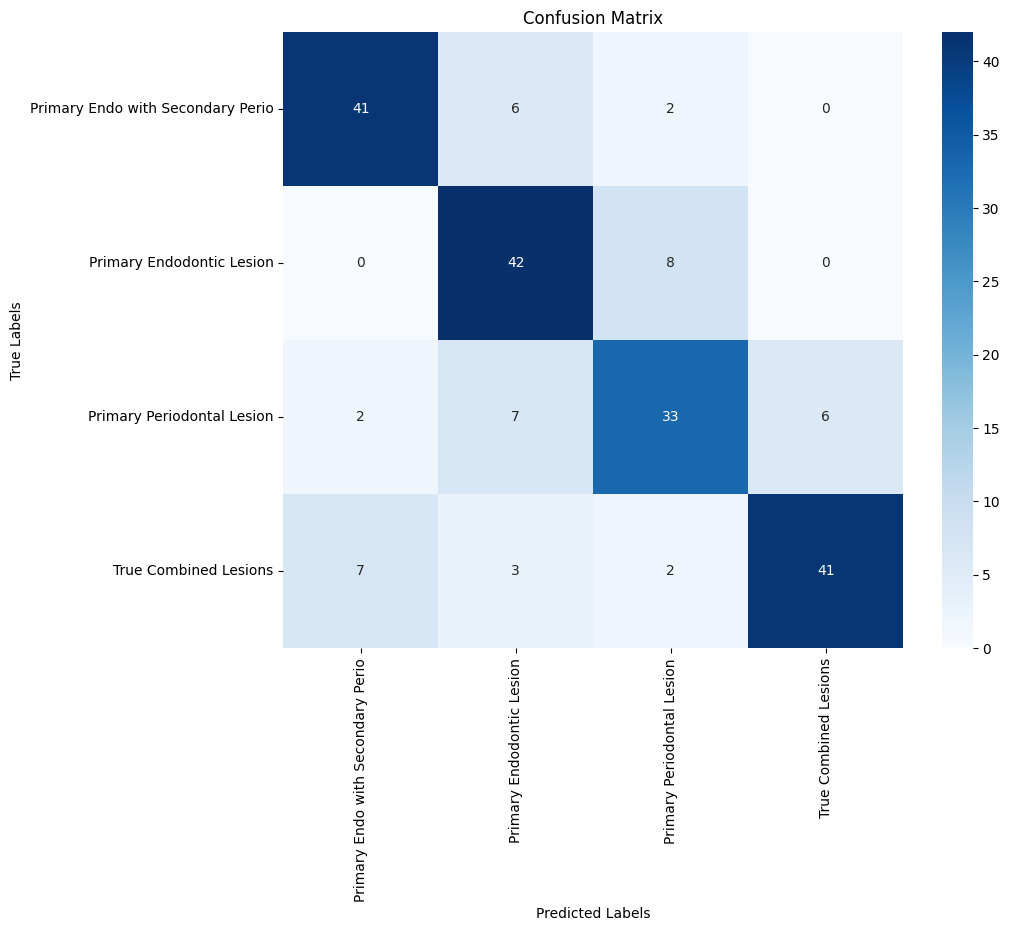

In [ ]:
test_generator.reset()
predictions = model7.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

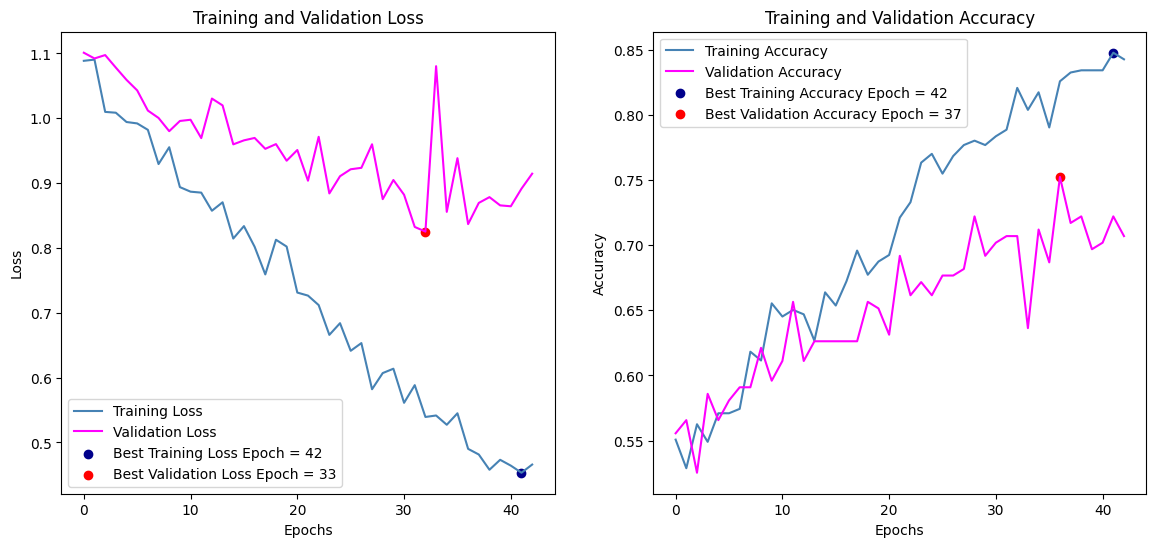

In [ ]:
# Mencari epoch dengan nilai terbaik
best_train_loss_epoch = np.argmin(history7.history['loss'])  # Epoch dengan loss training terbaik
best_val_loss_epoch = np.argmin(history7.history['val_loss'])  # Epoch dengan loss validasi terbaik
best_train_acc_epoch = np.argmax(history7.history['accuracy'])  # Epoch dengan akurasi training terbaik
best_val_acc_epoch = np.argmax(history7.history['val_accuracy'])  # Epoch dengan akurasi validasi terbaik

# Plot loss dan akurasi pada dua subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Training dan Validation Loss
ax1.plot(history7.history['loss'], label='Training Loss', color='steelblue')  # Grafik loss training
ax1.plot(history7.history['val_loss'], label='Validation Loss', color='magenta')  # Grafik loss validasi

# Titik pada epoch dengan Loss terbaik
ax1.scatter(best_train_loss_epoch, history7.history['loss'][best_train_loss_epoch],
            label=f'Best Training Loss Epoch = {best_train_loss_epoch + 1}', color='darkblue')  # Titik terbaik training
ax1.scatter(best_val_loss_epoch, history7.history['val_loss'][best_val_loss_epoch],
            label=f'Best Validation Loss Epoch = {best_val_loss_epoch + 1}', color='red')  # Titik terbaik validasi

ax1.set_title('Training and Validation Loss')  # Judul subplot
ax1.set_xlabel('Epochs')  # Label sumbu X
ax1.set_ylabel('Loss')  # Label sumbu Y
ax1.legend()  # Menampilkan legenda

# Subplot 2: Training dan Validation Accuracy
ax2.plot(history7.history['accuracy'], label='Training Accuracy', color='steelblue')  # Grafik akurasi training
ax2.plot(history7.history['val_accuracy'], label='Validation Accuracy', color='magenta')  # Grafik akurasi validasi

# Titik pada epoch dengan Accuracy terbaik
ax2.scatter(best_train_acc_epoch, history7.history['accuracy'][best_train_acc_epoch],
            label=f'Best Training Accuracy Epoch = {best_train_acc_epoch + 1}', color='darkblue')  # Titik terbaik training
ax2.scatter(best_val_acc_epoch, history7.history['val_accuracy'][best_val_acc_epoch],
            label=f'Best Validation Accuracy Epoch = {best_val_acc_epoch + 1}', color='red')  # Titik terbaik validasi

ax2.set_title('Training and Validation Accuracy')  # Judul subplot
ax2.set_xlabel('Epochs')  # Label sumbu X
ax2.set_ylabel('Accuracy')  # Label sumbu Y
ax2.legend()  # Menampilkan legenda

# Tampilkan grafik
plt.show()

In [ ]:
# Menampilkan precision, recall, f1-score, dan accuracy
precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

Precision: 0.79
Recall: 0.79
F1-Score: 0.78
Accuracy: 0.79


In [ ]:
# Menghitung precision, recall, f1-score, dan accuracy
precision, recall, f1, support = precision_recall_fscore_support(true_classes, predicted_classes, average=None)
weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

# Menampilkan hasil per kelas
print("Per-Class Metrics:")
for i, label in enumerate(class_labels):
    print(f"Class '{label}':")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall: {recall[i]:.2f}")
    print(f"  F1-Score: {f1[i]:.2f}")
    print(f"  Support: {support[i]}")
    print()

# Menampilkan hasil rata-rata tertimbang dan akurasi
print("Overall Metrics:")
print(f"Weighted Precision: {weighted_precision:.2f}")
print(f"Weighted Recall: {weighted_recall:.2f}")
print(f"Weighted F1-Score: {weighted_f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

# Menampilkan hasil dalam bentuk tabel menggunakan pandas (opsional)
import pandas as pd

metrics_df = pd.DataFrame({
    'Class': class_labels,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

metrics_df.loc['Weighted Average'] = ['Overall', weighted_precision, weighted_recall, weighted_f1, sum(support)]

print("\nMetrics Table:")
print(metrics_df)


Per-Class Metrics:
Class 'Primary Endo with Secondary Perio':
  Precision: 0.82
  Recall: 0.84
  F1-Score: 0.83
  Support: 49

Class 'Primary Endodontic Lesion':
  Precision: 0.72
  Recall: 0.84
  F1-Score: 0.78
  Support: 50

Class 'Primary Periodontal Lesion':
  Precision: 0.73
  Recall: 0.69
  F1-Score: 0.71
  Support: 48

Class 'True Combined Lesions':
  Precision: 0.87
  Recall: 0.77
  F1-Score: 0.82
  Support: 53

Overall Metrics:
Weighted Precision: 0.79
Weighted Recall: 0.79
Weighted F1-Score: 0.78
Accuracy: 0.79

Metrics Table:
                                              Class  Precision    Recall  \
0                 Primary Endo with Secondary Perio   0.820000  0.836735   
1                         Primary Endodontic Lesion   0.724138  0.840000   
2                        Primary Periodontal Lesion   0.733333  0.687500   
3                             True Combined Lesions   0.872340  0.773585   
Weighted Average                            Overall   0.789105  0.785000   



# Hyperparameter 3_2

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load ResNet50V2 (alternatively, ResNet101V2 or ResNet152V2)
base_model = resnet_v2.ResNet101V2(
    weights='imagenet',          # Pretrained weights
    include_top=False,           # Exclude fully connected layers
    input_shape=(224, 224, 3)    # Input image size
)

# Freeze all layers except the last few
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Membangun model baru di atas base model VGG16
model8 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Kompilasi model
model8.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model8.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)             │ (None, 7, 7, 2048)          │      42,626,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,840,388 (167.24 MB)

 Trainable params: 2,268,548 (8.65 MB)

 Non-trainable params: 41,571,840 (158.58 MB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
]


In [ ]:
history8 = model8.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.2660 - loss: 1.6628 - val_accuracy: 0.2677 - val_loss: 1.4186 - learning_rate: 1.0000e-04
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 605ms/step - accuracy: 0.2763 - loss: 1.4876 - val_accuracy: 0.3232 - val_loss: 1.3581 - learning_rate: 1.0000e-04
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 485ms/step - accuracy: 0.2615 - loss: 1.4910 - val_accuracy: 0.3485 - val_loss: 1.3300 - learning_rate: 1.0000e-04
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 601ms/step - accuracy: 0.3038 - loss: 1.4522 - val_accuracy: 0.3990 - val_loss: 1.3187 - learning_rate: 1.0000e-04
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 670ms/step - accuracy: 0.3598 - loss: 1.3824 - val_accuracy: 0.3889 - val_loss: 1.2901 - learning_rate: 1.0000e-04
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 488ms/step - accuracy: 0.3741 - loss: 1.3603 - val_accuracy: 0.4394 - val_loss: 1.2592 - learning_rate: 1.0000e-04
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 502ms/step - accura

In [ ]:
# Evaluasi Model
test_loss, test_accuracy = model8.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 832ms/step - accuracy: 0.7647 - loss: 0.7760
Test Accuracy: 73.00%


7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step


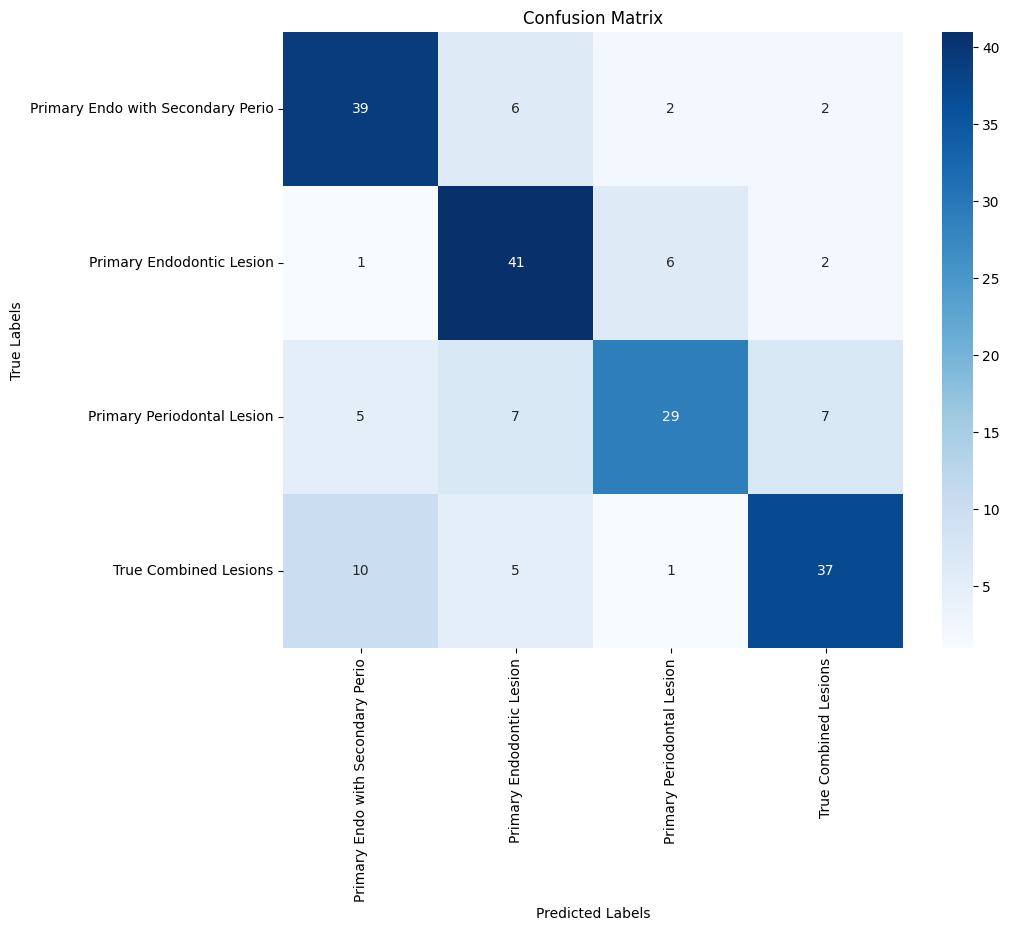

In [ ]:
test_generator.reset()
predictions = model8.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

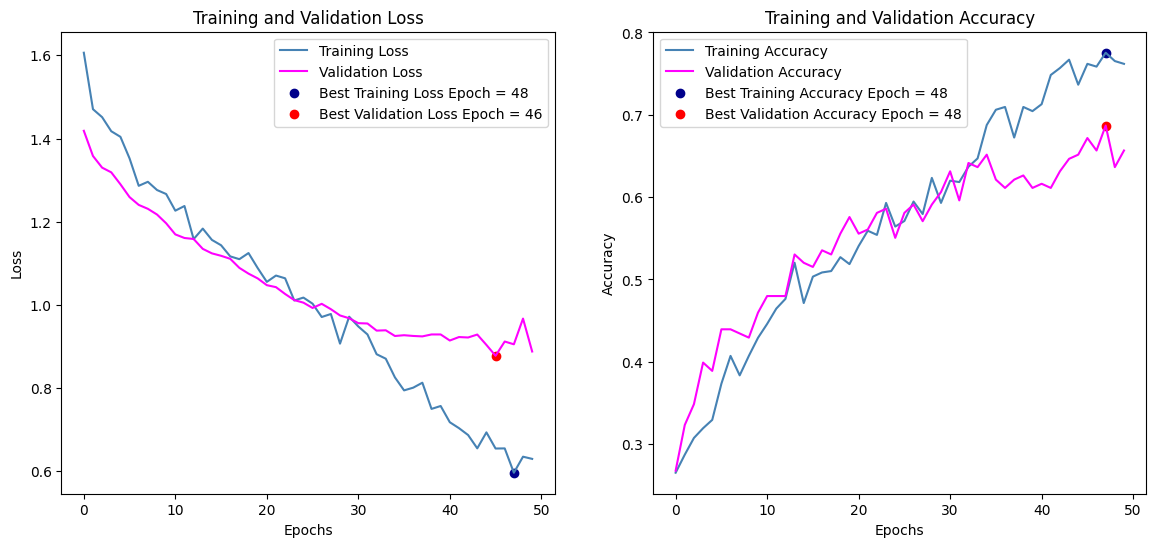

In [ ]:
# Mencari epoch dengan nilai terbaik
best_train_loss_epoch = np.argmin(history8.history['loss'])  # Epoch dengan loss training terbaik
best_val_loss_epoch = np.argmin(history8.history['val_loss'])  # Epoch dengan loss validasi terbaik
best_train_acc_epoch = np.argmax(history8.history['accuracy'])  # Epoch dengan akurasi training terbaik
best_val_acc_epoch = np.argmax(history8.history['val_accuracy'])  # Epoch dengan akurasi validasi terbaik

# Plot loss dan akurasi pada dua subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Training dan Validation Loss
ax1.plot(history8.history['loss'], label='Training Loss', color='steelblue')  # Grafik loss training
ax1.plot(history8.history['val_loss'], label='Validation Loss', color='magenta')  # Grafik loss validasi

# Titik pada epoch dengan Loss terbaik
ax1.scatter(best_train_loss_epoch, history8.history['loss'][best_train_loss_epoch],
            label=f'Best Training Loss Epoch = {best_train_loss_epoch + 1}', color='darkblue')  # Titik terbaik training
ax1.scatter(best_val_loss_epoch, history8.history['val_loss'][best_val_loss_epoch],
            label=f'Best Validation Loss Epoch = {best_val_loss_epoch + 1}', color='red')  # Titik terbaik validasi

ax1.set_title('Training and Validation Loss')  # Judul subplot
ax1.set_xlabel('Epochs')  # Label sumbu X
ax1.set_ylabel('Loss')  # Label sumbu Y
ax1.legend()  # Menampilkan legenda

# Subplot 2: Training dan Validation Accuracy
ax2.plot(history8.history['accuracy'], label='Training Accuracy', color='steelblue')  # Grafik akurasi training
ax2.plot(history8.history['val_accuracy'], label='Validation Accuracy', color='magenta')  # Grafik akurasi validasi

# Titik pada epoch dengan Accuracy terbaik
ax2.scatter(best_train_acc_epoch, history8.history['accuracy'][best_train_acc_epoch],
            label=f'Best Training Accuracy Epoch = {best_train_acc_epoch + 1}', color='darkblue')  # Titik terbaik training
ax2.scatter(best_val_acc_epoch, history8.history['val_accuracy'][best_val_acc_epoch],
            label=f'Best Validation Accuracy Epoch = {best_val_acc_epoch + 1}', color='red')  # Titik terbaik validasi

ax2.set_title('Training and Validation Accuracy')  # Judul subplot
ax2.set_xlabel('Epochs')  # Label sumbu X
ax2.set_ylabel('Accuracy')  # Label sumbu Y
ax2.legend()  # Menampilkan legenda

# Tampilkan grafik
plt.show()

In [ ]:
# Menampilkan precision, recall, f1-score, dan accuracy
precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

Precision: 0.73
Recall: 0.73
F1-Score: 0.73
Accuracy: 0.73


In [ ]:
# Menghitung precision, recall, f1-score, dan accuracy
precision, recall, f1, support = precision_recall_fscore_support(true_classes, predicted_classes, average=None)
weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

# Menampilkan hasil per kelas
print("Per-Class Metrics:")
for i, label in enumerate(class_labels):
    print(f"Class '{label}':")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall: {recall[i]:.2f}")
    print(f"  F1-Score: {f1[i]:.2f}")
    print(f"  Support: {support[i]}")
    print()

# Menampilkan hasil rata-rata tertimbang dan akurasi
print("Overall Metrics:")
print(f"Weighted Precision: {weighted_precision:.2f}")
print(f"Weighted Recall: {weighted_recall:.2f}")
print(f"Weighted F1-Score: {weighted_f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

# Menampilkan hasil dalam bentuk tabel menggunakan pandas (opsional)
import pandas as pd

metrics_df = pd.DataFrame({
    'Class': class_labels,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

metrics_df.loc['Weighted Average'] = ['Overall', weighted_precision, weighted_recall, weighted_f1, sum(support)]

print("\nMetrics Table:")
print(metrics_df)


Per-Class Metrics:
Class 'Primary Endo with Secondary Perio':
  Precision: 0.71
  Recall: 0.80
  F1-Score: 0.75
  Support: 49

Class 'Primary Endodontic Lesion':
  Precision: 0.69
  Recall: 0.82
  F1-Score: 0.75
  Support: 50

Class 'Primary Periodontal Lesion':
  Precision: 0.76
  Recall: 0.60
  F1-Score: 0.67
  Support: 48

Class 'True Combined Lesions':
  Precision: 0.77
  Recall: 0.70
  F1-Score: 0.73
  Support: 53

Overall Metrics:
Weighted Precision: 0.73
Weighted Recall: 0.73
Weighted F1-Score: 0.73
Accuracy: 0.73

Metrics Table:
                                              Class  Precision    Recall  \
0                 Primary Endo with Secondary Perio   0.709091  0.795918   
1                         Primary Endodontic Lesion   0.694915  0.820000   
2                        Primary Periodontal Lesion   0.763158  0.604167   
3                             True Combined Lesions   0.770833  0.698113   
Weighted Average                            Overall   0.734885  0.730000   



# Hyperparameter 3_3



In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load ResNet50V2 (alternatively, ResNet101V2 or ResNet152V2)
base_model = resnet_v2.ResNet101V2(
    weights='imagenet',          # Pretrained weights
    include_top=False,           # Exclude fully connected layers
    input_shape=(224, 224, 3)    # Input image size
)

# Freeze all layers except the last few
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Membangun model baru di atas base model VGG16
model9 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Kompilasi model
model9.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model9.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)             │ (None, 7, 7, 2048)          │      42,626,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,192,516 (164.77 MB)

 Trainable params: 1,620,676 (6.18 MB)

 Non-trainable params: 41,571,840 (158.58 MB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
]


In [ ]:
history9 = model9.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.2417 - loss: 1.5552 - val_accuracy: 0.3384 - val_loss: 1.3454 - learning_rate: 1.0000e-04
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 567ms/step - accuracy: 0.3185 - loss: 1.3933 - val_accuracy: 0.3535 - val_loss: 1.3248 - learning_rate: 1.0000e-04
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 576ms/step - accuracy: 0.3297 - loss: 1.3723 - val_accuracy: 0.3990 - val_loss: 1.2897 - learning_rate: 1.0000e-04
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 605ms/step - accuracy: 0.3801 - loss: 1.3640 - val_accuracy: 0.3889 - val_loss: 1.2645 - learning_rate: 1.0000e-04
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 593ms/step - accuracy: 0.3937 - loss: 1.2936 - val_accuracy: 0.3889 - val_loss: 1.2445 - learning_rate: 1.0000e-04
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 611ms/step - accuracy: 0.4130 - loss: 1.2826 - val_accuracy: 0.4242 - val_loss: 1.2290 - learning_rate: 1.0000e-04
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 648ms/step - accura

In [ ]:
# Evaluasi Model
test_loss, test_accuracy = model9.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 620ms/step - accuracy: 0.7661 - loss: 0.7339
Test Accuracy: 71.50%


7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step


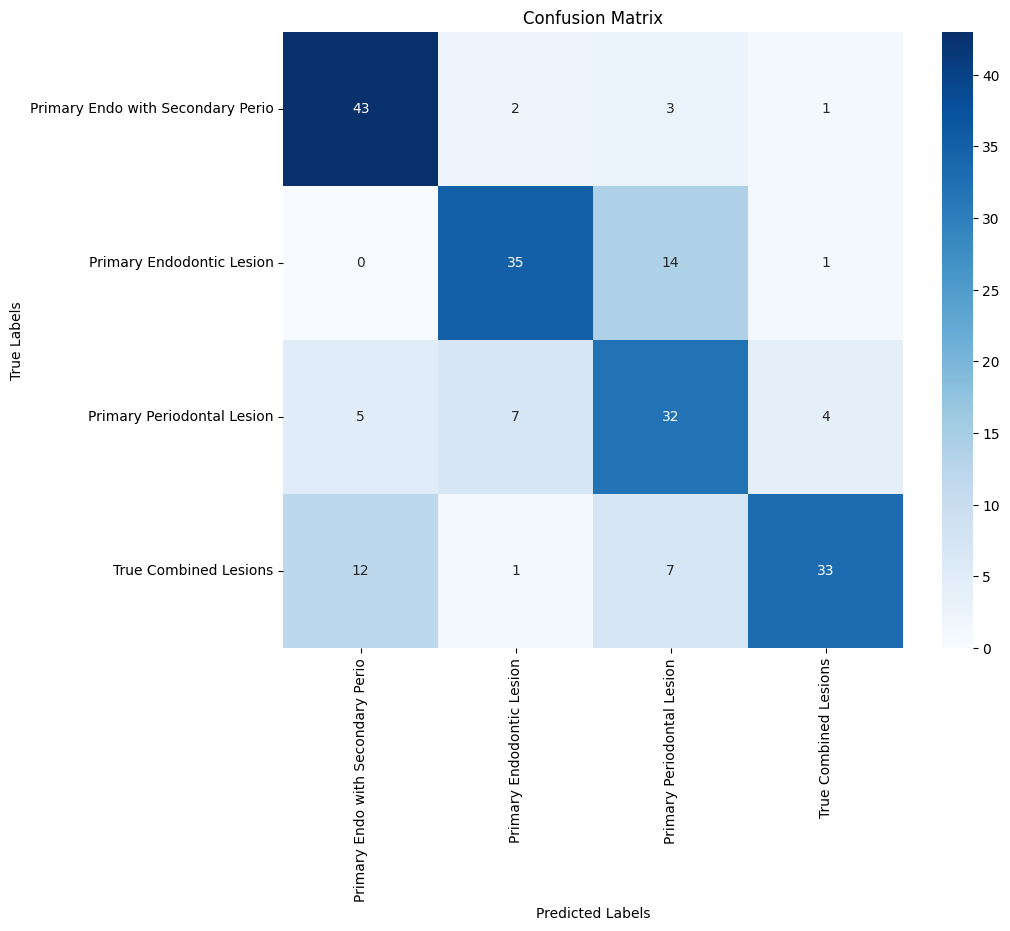

In [ ]:
test_generator.reset()
predictions = model9.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

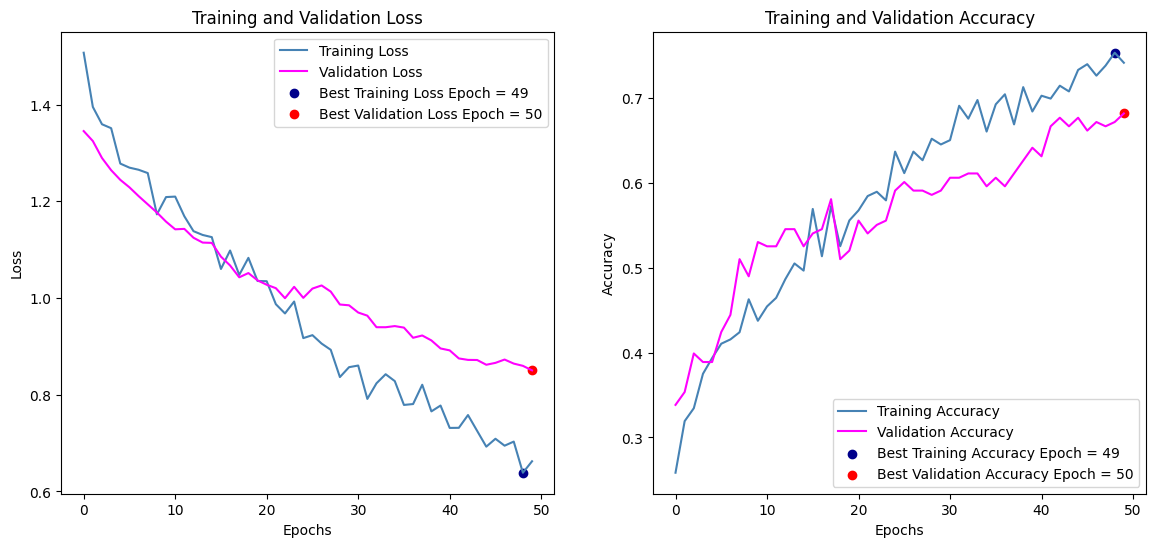

In [ ]:
# Mencari epoch dengan nilai terbaik
best_train_loss_epoch = np.argmin(history9.history['loss'])  # Epoch dengan loss training terbaik
best_val_loss_epoch = np.argmin(history9.history['val_loss'])  # Epoch dengan loss validasi terbaik
best_train_acc_epoch = np.argmax(history9.history['accuracy'])  # Epoch dengan akurasi training terbaik
best_val_acc_epoch = np.argmax(history9.history['val_accuracy'])  # Epoch dengan akurasi validasi terbaik

# Plot loss dan akurasi pada dua subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Training dan Validation Loss
ax1.plot(history9.history['loss'], label='Training Loss', color='steelblue')  # Grafik loss training
ax1.plot(history9.history['val_loss'], label='Validation Loss', color='magenta')  # Grafik loss validasi

# Titik pada epoch dengan Loss terbaik
ax1.scatter(best_train_loss_epoch, history9.history['loss'][best_train_loss_epoch],
            label=f'Best Training Loss Epoch = {best_train_loss_epoch + 1}', color='darkblue')  # Titik terbaik training
ax1.scatter(best_val_loss_epoch, history9.history['val_loss'][best_val_loss_epoch],
            label=f'Best Validation Loss Epoch = {best_val_loss_epoch + 1}', color='red')  # Titik terbaik validasi

ax1.set_title('Training and Validation Loss')  # Judul subplot
ax1.set_xlabel('Epochs')  # Label sumbu X
ax1.set_ylabel('Loss')  # Label sumbu Y
ax1.legend()  # Menampilkan legenda

# Subplot 2: Training dan Validation Accuracy
ax2.plot(history9.history['accuracy'], label='Training Accuracy', color='steelblue')  # Grafik akurasi training
ax2.plot(history9.history['val_accuracy'], label='Validation Accuracy', color='magenta')  # Grafik akurasi validasi

# Titik pada epoch dengan Accuracy terbaik
ax2.scatter(best_train_acc_epoch, history9.history['accuracy'][best_train_acc_epoch],
            label=f'Best Training Accuracy Epoch = {best_train_acc_epoch + 1}', color='darkblue')  # Titik terbaik training
ax2.scatter(best_val_acc_epoch, history9.history['val_accuracy'][best_val_acc_epoch],
            label=f'Best Validation Accuracy Epoch = {best_val_acc_epoch + 1}', color='red')  # Titik terbaik validasi

ax2.set_title('Training and Validation Accuracy')  # Judul subplot
ax2.set_xlabel('Epochs')  # Label sumbu X
ax2.set_ylabel('Accuracy')  # Label sumbu Y
ax2.legend()  # Menampilkan legenda

# Tampilkan grafik
plt.show()

In [ ]:
# Menampilkan precision, recall, f1-score, dan accuracy
precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

Precision: 0.73
Recall: 0.71
F1-Score: 0.72
Accuracy: 0.71


In [ ]:
# Menghitung precision, recall, f1-score, dan accuracy
precision, recall, f1, support = precision_recall_fscore_support(true_classes, predicted_classes, average=None)
weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

# Menampilkan hasil per kelas
print("Per-Class Metrics:")
for i, label in enumerate(class_labels):
    print(f"Class '{label}':")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall: {recall[i]:.2f}")
    print(f"  F1-Score: {f1[i]:.2f}")
    print(f"  Support: {support[i]}")
    print()

# Menampilkan hasil rata-rata tertimbang dan akurasi
print("Overall Metrics:")
print(f"Weighted Precision: {weighted_precision:.2f}")
print(f"Weighted Recall: {weighted_recall:.2f}")
print(f"Weighted F1-Score: {weighted_f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

# Menampilkan hasil dalam bentuk tabel menggunakan pandas (opsional)
import pandas as pd

metrics_df = pd.DataFrame({
    'Class': class_labels,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

metrics_df.loc['Weighted Average'] = ['Overall', weighted_precision, weighted_recall, weighted_f1, sum(support)]

print("\nMetrics Table:")
print(metrics_df)


Per-Class Metrics:
Class 'Primary Endo with Secondary Perio':
  Precision: 0.72
  Recall: 0.88
  F1-Score: 0.79
  Support: 49

Class 'Primary Endodontic Lesion':
  Precision: 0.78
  Recall: 0.70
  F1-Score: 0.74
  Support: 50

Class 'Primary Periodontal Lesion':
  Precision: 0.57
  Recall: 0.67
  F1-Score: 0.62
  Support: 48

Class 'True Combined Lesions':
  Precision: 0.85
  Recall: 0.62
  F1-Score: 0.72
  Support: 53

Overall Metrics:
Weighted Precision: 0.73
Weighted Recall: 0.71
Weighted F1-Score: 0.72
Accuracy: 0.71

Metrics Table:
                                              Class  Precision    Recall  \
0                 Primary Endo with Secondary Perio   0.716667  0.877551   
1                         Primary Endodontic Lesion   0.777778  0.700000   
2                        Primary Periodontal Lesion   0.571429  0.666667   
3                             True Combined Lesions   0.846154  0.622642   
Weighted Average                            Overall   0.731401  0.715000   



# pakai augmentasi validasi

In [ ]:
# Generator untuk data train
train_generator1 = train_datagen.flow_from_directory(
    '/content/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Generator untuk data validation
validation_generator1 = train_datagen.flow_from_directory(
    '/content/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Generator untuk data test
test_generator1 = test_datagen.flow_from_directory(
    '/content/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 592 images belonging to 4 classes.
Found 198 images belonging to 4 classes.
Found 200 images belonging to 4 classes.


# Resnet101v2

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load ResNet50V2 (alternatively, ResNet101V2 or ResNet152V2)
base_model = resnet_v2.ResNet101V2(
    weights='imagenet',          # Pretrained weights
    include_top=False,           # Exclude fully connected layers
    input_shape=(224, 224, 3)    # Input image size
)

# Freeze all layers except the last few
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Membangun model baru di atas base model VGG16
model4 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Kompilasi model
model4.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model4.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)             │ (None, 7, 7, 2048)          │      42,626,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,897,348 (163.64 MB)

 Trainable params: 1,325,508 (5.06 MB)

 Non-trainable params: 41,571,840 (158.58 MB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
]


In [ ]:
history4 = model4.fit(
    train_generator1,
    validation_data=validation_generator1,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.2572 - loss: 1.5498 - val_accuracy: 0.3081 - val_loss: 1.3663 - learning_rate: 1.0000e-04
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 689ms/step - accuracy: 0.2890 - loss: 1.4861 - val_accuracy: 0.4040 - val_loss: 1.3038 - learning_rate: 1.0000e-04
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 624ms/step - accuracy: 0.3299 - loss: 1.3666 - val_accuracy: 0.3838 - val_loss: 1.2927 - learning_rate: 1.0000e-04
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 669ms/step - accuracy: 0.3914 - loss: 1.3141 - val_accuracy: 0.4040 - val_loss: 1.2651 - learning_rate: 1.0000e-04
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 686ms/step - accuracy: 0.3445 - loss: 1.3240 - val_accuracy: 0.3939 - val_loss: 1.2644 - learning_rate: 1.0000e-04
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 22s 682ms/step - accuracy: 0.4194 - loss: 1.2656 - val_accuracy: 0.5152 - val_loss: 1.2193 - learning_rate: 1.0000e-04
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 670ms/step - accuracy: 0.4842 

In [ ]:
# Evaluasi Model
test_loss, test_accuracy = model4.evaluate(test_generator1)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 579ms/step - accuracy: 0.7717 - loss: 0.7350
Test Accuracy: 70.50%


7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step


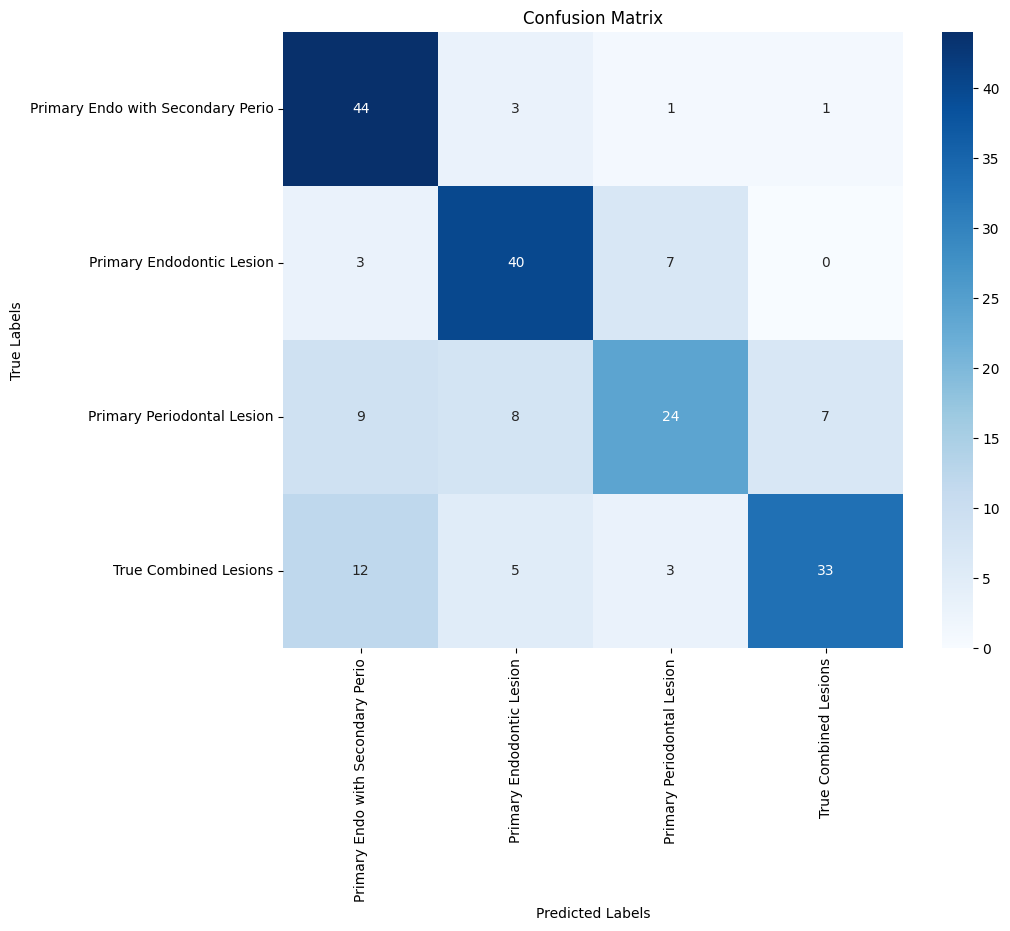

In [ ]:
test_generator1.reset()
predictions = model4.predict(test_generator1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator1.classes
class_labels = list(test_generator1.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

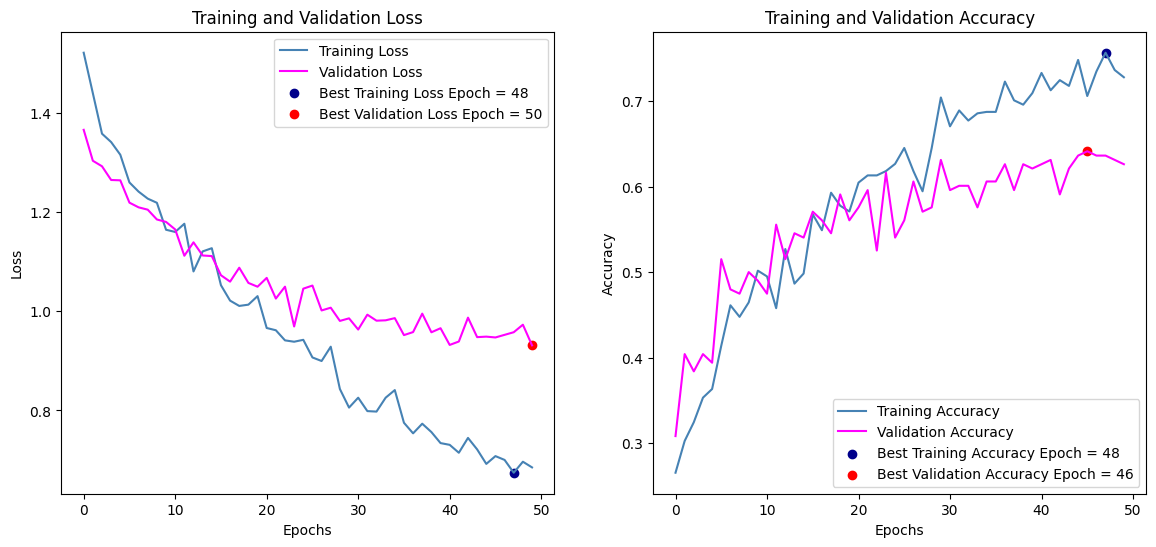

In [ ]:
# Mencari epoch dengan nilai terbaik
best_train_loss_epoch = np.argmin(history4.history['loss'])  # Epoch dengan loss training terbaik
best_val_loss_epoch = np.argmin(history4.history['val_loss'])  # Epoch dengan loss validasi terbaik
best_train_acc_epoch = np.argmax(history4.history['accuracy'])  # Epoch dengan akurasi training terbaik
best_val_acc_epoch = np.argmax(history4.history['val_accuracy'])  # Epoch dengan akurasi validasi terbaik

# Plot loss dan akurasi pada dua subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Training dan Validation Loss
ax1.plot(history4.history['loss'], label='Training Loss', color='steelblue')  # Grafik loss training
ax1.plot(history4.history['val_loss'], label='Validation Loss', color='magenta')  # Grafik loss validasi

# Titik pada epoch dengan Loss terbaik
ax1.scatter(best_train_loss_epoch, history4.history['loss'][best_train_loss_epoch],
            label=f'Best Training Loss Epoch = {best_train_loss_epoch + 1}', color='darkblue')  # Titik terbaik training
ax1.scatter(best_val_loss_epoch, history4.history['val_loss'][best_val_loss_epoch],
            label=f'Best Validation Loss Epoch = {best_val_loss_epoch + 1}', color='red')  # Titik terbaik validasi

ax1.set_title('Training and Validation Loss')  # Judul subplot
ax1.set_xlabel('Epochs')  # Label sumbu X
ax1.set_ylabel('Loss')  # Label sumbu Y
ax1.legend()  # Menampilkan legenda

# Subplot 2: Training dan Validation Accuracy
ax2.plot(history4.history['accuracy'], label='Training Accuracy', color='steelblue')  # Grafik akurasi training
ax2.plot(history4.history['val_accuracy'], label='Validation Accuracy', color='magenta')  # Grafik akurasi validasi

# Titik pada epoch dengan Accuracy terbaik
ax2.scatter(best_train_acc_epoch, history4.history['accuracy'][best_train_acc_epoch],
            label=f'Best Training Accuracy Epoch = {best_train_acc_epoch + 1}', color='darkblue')  # Titik terbaik training
ax2.scatter(best_val_acc_epoch, history4.history['val_accuracy'][best_val_acc_epoch],
            label=f'Best Validation Accuracy Epoch = {best_val_acc_epoch + 1}', color='red')  # Titik terbaik validasi

ax2.set_title('Training and Validation Accuracy')  # Judul subplot
ax2.set_xlabel('Epochs')  # Label sumbu X
ax2.set_ylabel('Accuracy')  # Label sumbu Y
ax2.legend()  # Menampilkan legenda

# Tampilkan grafik
plt.show()

In [ ]:
# Menampilkan precision, recall, f1-score, dan accuracy
precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

Precision: 0.71
Recall: 0.70
F1-Score: 0.70
Accuracy: 0.70


In [ ]:
# Menghitung precision, recall, f1-score, dan accuracy
precision, recall, f1, support = precision_recall_fscore_support(true_classes, predicted_classes, average=None)
weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

# Menampilkan hasil per kelas
print("Per-Class Metrics:")
for i, label in enumerate(class_labels):
    print(f"Class '{label}':")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall: {recall[i]:.2f}")
    print(f"  F1-Score: {f1[i]:.2f}")
    print(f"  Support: {support[i]}")
    print()

# Menampilkan hasil rata-rata tertimbang dan akurasi
print("Overall Metrics:")
print(f"Weighted Precision: {weighted_precision:.2f}")
print(f"Weighted Recall: {weighted_recall:.2f}")
print(f"Weighted F1-Score: {weighted_f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

# Menampilkan hasil dalam bentuk tabel menggunakan pandas (opsional)
import pandas as pd

metrics_df = pd.DataFrame({
    'Class': class_labels,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

metrics_df.loc['Weighted Average'] = ['Overall', weighted_precision, weighted_recall, weighted_f1, sum(support)]

print("\nMetrics Table:")
print(metrics_df)


Per-Class Metrics:
Class 'Primary Endo with Secondary Perio':
  Precision: 0.65
  Recall: 0.90
  F1-Score: 0.75
  Support: 49

Class 'Primary Endodontic Lesion':
  Precision: 0.71
  Recall: 0.80
  F1-Score: 0.75
  Support: 50

Class 'Primary Periodontal Lesion':
  Precision: 0.69
  Recall: 0.50
  F1-Score: 0.58
  Support: 48

Class 'True Combined Lesions':
  Precision: 0.80
  Recall: 0.62
  F1-Score: 0.70
  Support: 53

Overall Metrics:
Weighted Precision: 0.71
Weighted Recall: 0.70
Weighted F1-Score: 0.70
Accuracy: 0.70

Metrics Table:
                                              Class  Precision    Recall  \
0                 Primary Endo with Secondary Perio   0.647059  0.897959   
1                         Primary Endodontic Lesion   0.714286  0.800000   
2                        Primary Periodontal Lesion   0.685714  0.500000   
3                             True Combined Lesions   0.804878  0.622642   
Weighted Average                            Overall   0.714965  0.705000   



# Hyperparameter 2

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load ResNet50V2 (alternatively, ResNet101V2 or ResNet152V2)
base_model = resnet_v2.ResNet101V2(
    weights='imagenet',          # Pretrained weights
    include_top=False,           # Exclude fully connected layers
    input_shape=(224, 224, 3)    # Input image size
)

# Freeze all layers except the last few
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Membangun model baru di atas base model VGG16
model5 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Kompilasi model
model5.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model5.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)             │ (None, 7, 7, 2048)          │      42,626,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_7           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,922,884 (163.74 MB)

 Trainable params: 1,351,044 (5.15 MB)

 Non-trainable params: 41,571,840 (158.58 MB)

In [ ]:
history5 = model5.fit(
    train_generator1,
    validation_data=validation_generator1,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.2647 - loss: 1.4964 - val_accuracy: 0.3737 - val_loss: 1.3269 - learning_rate: 1.0000e-04
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 664ms/step - accuracy: 0.2797 - loss: 1.4340 - val_accuracy: 0.4091 - val_loss: 1.2898 - learning_rate: 1.0000e-04
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 636ms/step - accuracy: 0.3092 - loss: 1.3792 - val_accuracy: 0.4646 - val_loss: 1.2333 - learning_rate: 1.0000e-04
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 641ms/step - accuracy: 0.4166 - loss: 1.2668 - val_accuracy: 0.4848 - val_loss: 1.2071 - learning_rate: 1.0000e-04
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 651ms/step - accuracy: 0.4535 - loss: 1.2416 - val_accuracy: 0.4646 - val_loss: 1.2005 - learning_rate: 1.0000e-04
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 668ms/step - accuracy: 0.4301 - loss: 1.2320 - val_accuracy: 0.5404 - val_loss: 1.1695 - learning_rate: 1.0000e-04
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 652ms/step - accura

In [ ]:
# Evaluasi Model
test_loss, test_accuracy = model5.evaluate(test_generator1)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 574ms/step - accuracy: 0.4018 - loss: 1.3059
Test Accuracy: 36.00%


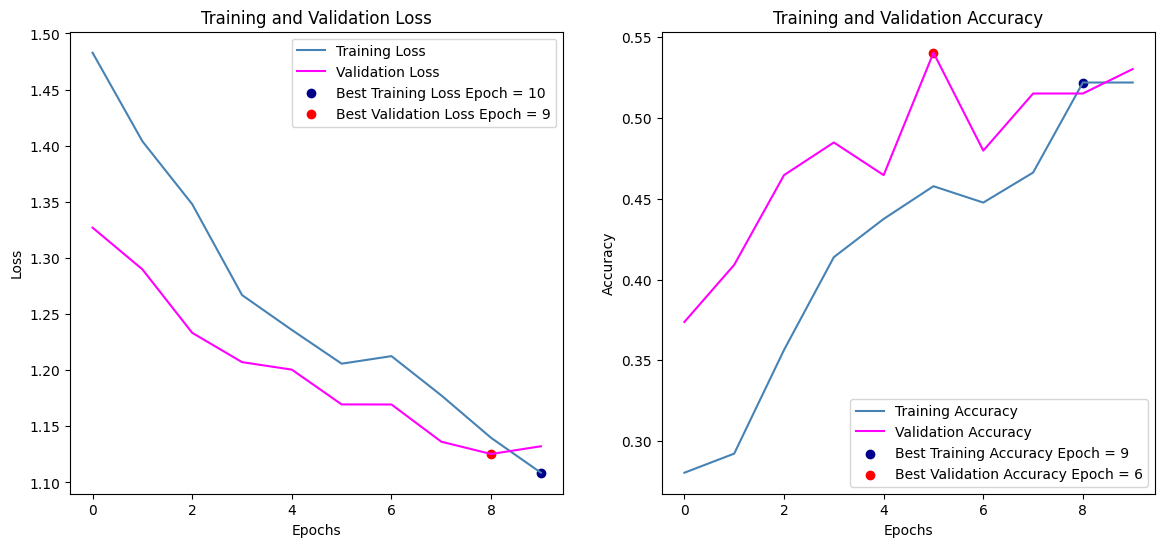

In [ ]:
# Mencari epoch dengan nilai terbaik
best_train_loss_epoch = np.argmin(history5.history['loss'])  # Epoch dengan loss training terbaik
best_val_loss_epoch = np.argmin(history5.history['val_loss'])  # Epoch dengan loss validasi terbaik
best_train_acc_epoch = np.argmax(history5.history['accuracy'])  # Epoch dengan akurasi training terbaik
best_val_acc_epoch = np.argmax(history5.history['val_accuracy'])  # Epoch dengan akurasi validasi terbaik

# Plot loss dan akurasi pada dua subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Training dan Validation Loss
ax1.plot(history5.history['loss'], label='Training Loss', color='steelblue')  # Grafik loss training
ax1.plot(history5.history['val_loss'], label='Validation Loss', color='magenta')  # Grafik loss validasi

# Titik pada epoch dengan Loss terbaik
ax1.scatter(best_train_loss_epoch, history5.history['loss'][best_train_loss_epoch],
            label=f'Best Training Loss Epoch = {best_train_loss_epoch + 1}', color='darkblue')  # Titik terbaik training
ax1.scatter(best_val_loss_epoch, history5.history['val_loss'][best_val_loss_epoch],
            label=f'Best Validation Loss Epoch = {best_val_loss_epoch + 1}', color='red')  # Titik terbaik validasi

ax1.set_title('Training and Validation Loss')  # Judul subplot
ax1.set_xlabel('Epochs')  # Label sumbu X
ax1.set_ylabel('Loss')  # Label sumbu Y
ax1.legend()  # Menampilkan legenda

# Subplot 2: Training dan Validation Accuracy
ax2.plot(history5.history['accuracy'], label='Training Accuracy', color='steelblue')  # Grafik akurasi training
ax2.plot(history5.history['val_accuracy'], label='Validation Accuracy', color='magenta')  # Grafik akurasi validasi

# Titik pada epoch dengan Accuracy terbaik
ax2.scatter(best_train_acc_epoch, history5.history['accuracy'][best_train_acc_epoch],
            label=f'Best Training Accuracy Epoch = {best_train_acc_epoch + 1}', color='darkblue')  # Titik terbaik training
ax2.scatter(best_val_acc_epoch, history5.history['val_accuracy'][best_val_acc_epoch],
            label=f'Best Validation Accuracy Epoch = {best_val_acc_epoch + 1}', color='red')  # Titik terbaik validasi

ax2.set_title('Training and Validation Accuracy')  # Judul subplot
ax2.set_xlabel('Epochs')  # Label sumbu X
ax2.set_ylabel('Accuracy')  # Label sumbu Y
ax2.legend()  # Menampilkan legenda

# Tampilkan grafik
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step


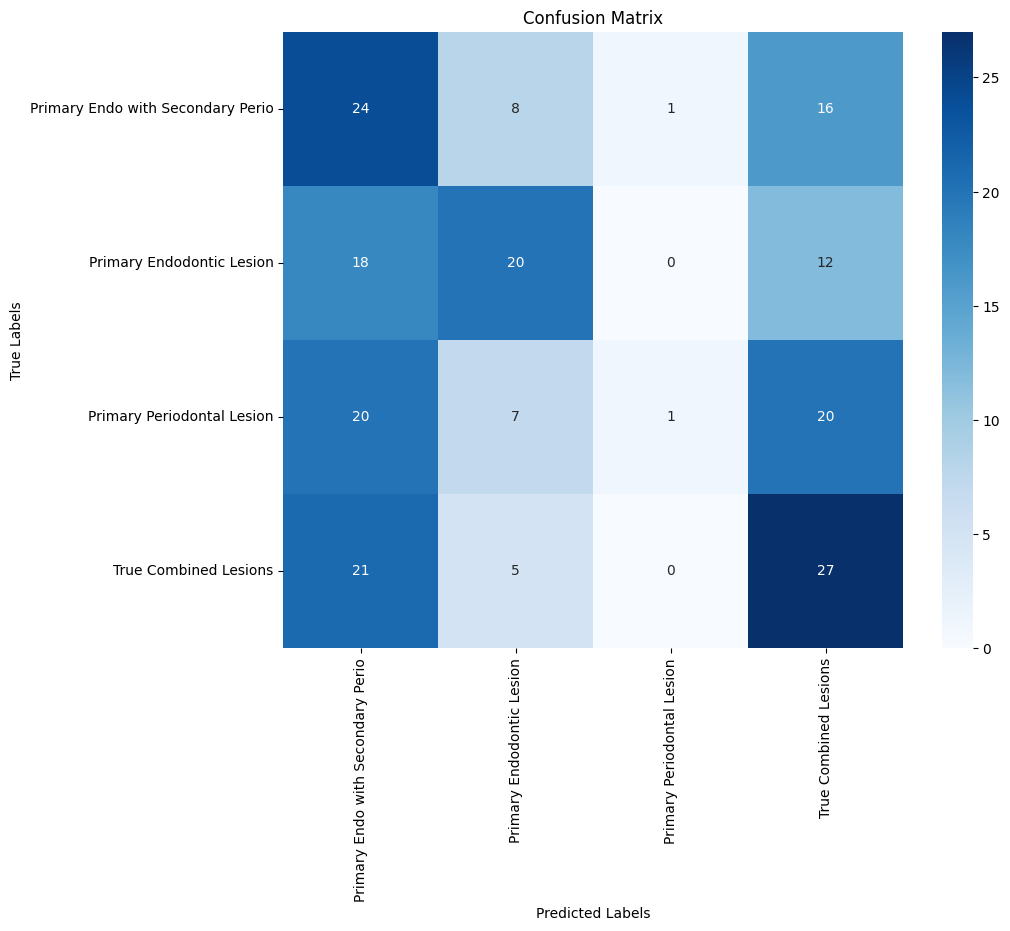

In [ ]:
test_generator1.reset()
predictions = model5.predict(test_generator1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator1.classes
class_labels = list(test_generator1.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Menampilkan precision, recall, f1-score, dan accuracy
precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

Precision: 0.41
Recall: 0.36
F1-Score: 0.32
Accuracy: 0.36


# Hyperparameter 2_1

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load ResNet50V2 (alternatively, ResNet101V2 or ResNet152V2)
base_model = resnet_v2.ResNet101V2(
    weights='imagenet',          # Pretrained weights
    include_top=False,           # Exclude fully connected layers
    input_shape=(224, 224, 3)    # Input image size
)

# Freeze all layers except the last few
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Membangun model baru di atas base model VGG16
model6 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')
])

# Kompilasi model
model6.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model6.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)             │ (None, 7, 7, 2048)          │      42,626,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_8           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,741,828 (166.86 MB)

 Trainable params: 2,169,988 (8.28 MB)

 Non-trainable params: 41,571,840 (158.58 MB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
]


In [ ]:
history6 = model6.fit(
    train_generator1,
    validation_data=validation_generator1,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.2813 - loss: 1.4364 - val_accuracy: 0.4141 - val_loss: 1.2891 - learning_rate: 1.0000e-04
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 771ms/step - accuracy: 0.5294 - loss: 1.1621 - val_accuracy: 0.4747 - val_loss: 1.1666 - learning_rate: 1.0000e-04
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 823ms/step - accuracy: 0.5361 - loss: 1.0840 - val_accuracy: 0.4899 - val_loss: 1.1340 - learning_rate: 1.0000e-04
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 772ms/step - accuracy: 0.6070 - loss: 1.0008 - val_accuracy: 0.4798 - val_loss: 1.1504 - learning_rate: 1.0000e-04
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 22s 801ms/step - accuracy: 0.6170 - loss: 0.9435 - val_accuracy: 0.5808 - val_loss: 1.0308 - learning_rate: 1.0000e-04
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.6691 - loss: 0.8767 - val_accuracy: 0.5455 - val_loss: 1.0164 - learning_rate: 1.0000e-04
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 832ms/step - accuracy:

In [ ]:
# Evaluasi Model
test_loss, test_accuracy = model6.evaluate(test_generator1)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7815 - loss: 0.6535
Test Accuracy: 74.00%


7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step


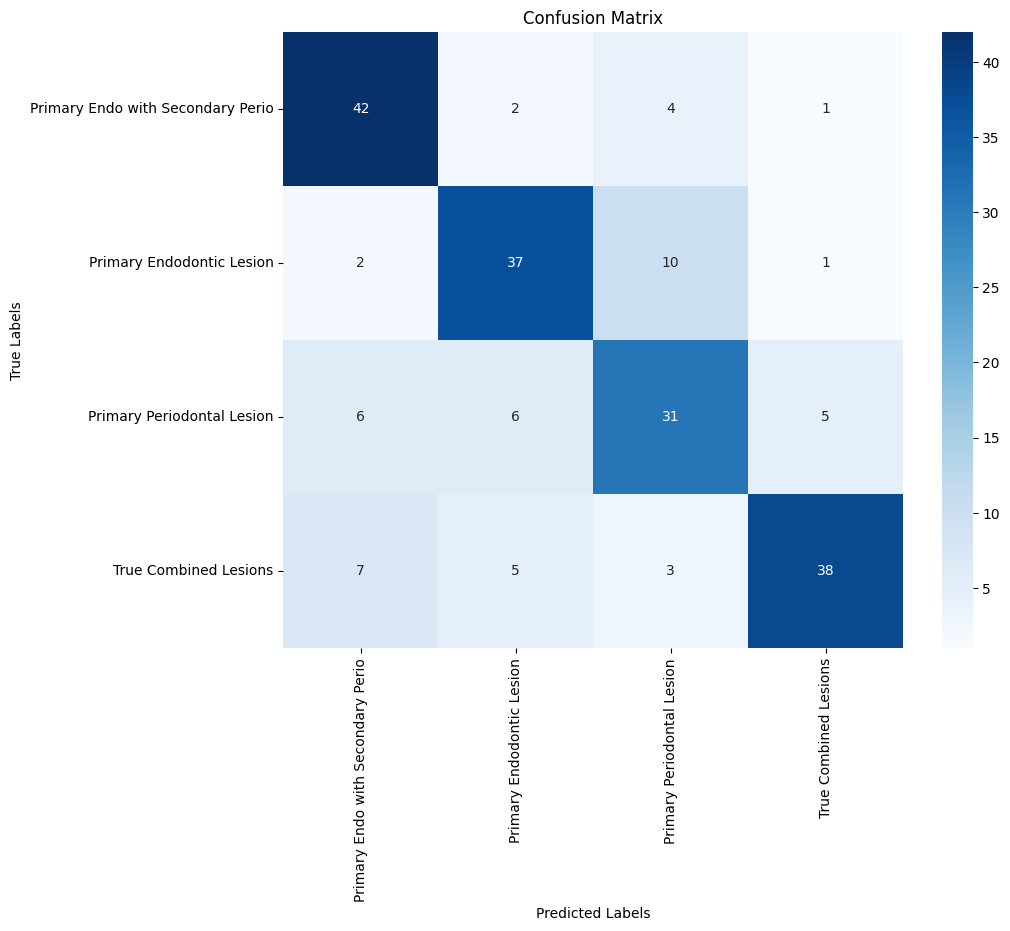

In [ ]:
test_generator1.reset()
predictions = model6.predict(test_generator1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator1.classes
class_labels = list(test_generator1.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

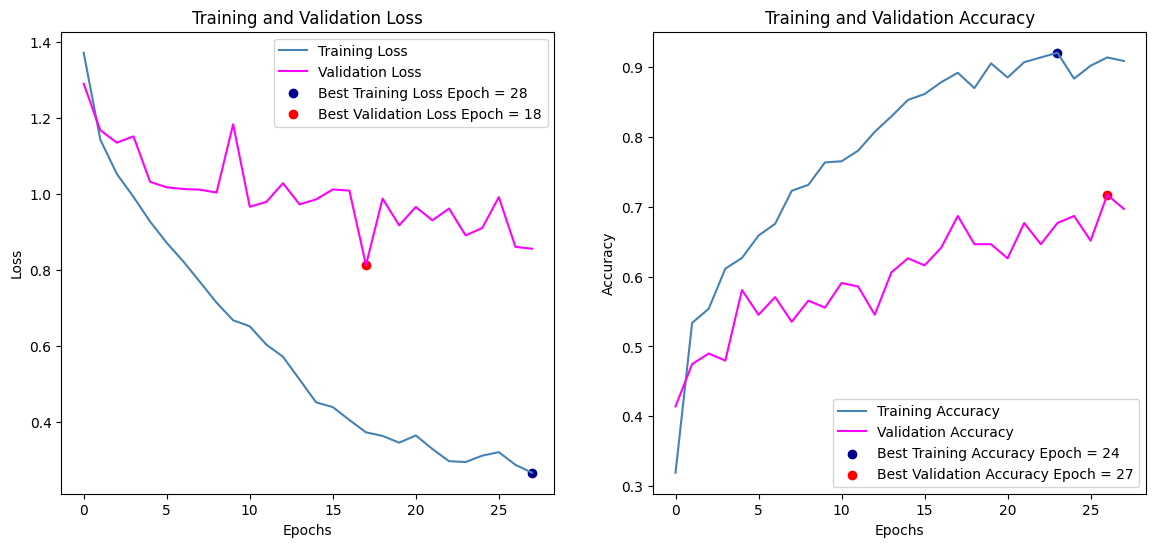

In [ ]:
# Mencari epoch dengan nilai terbaik
best_train_loss_epoch = np.argmin(history6.history['loss'])  # Epoch dengan loss training terbaik
best_val_loss_epoch = np.argmin(history6.history['val_loss'])  # Epoch dengan loss validasi terbaik
best_train_acc_epoch = np.argmax(history6.history['accuracy'])  # Epoch dengan akurasi training terbaik
best_val_acc_epoch = np.argmax(history6.history['val_accuracy'])  # Epoch dengan akurasi validasi terbaik

# Plot loss dan akurasi pada dua subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Training dan Validation Loss
ax1.plot(history6.history['loss'], label='Training Loss', color='steelblue')  # Grafik loss training
ax1.plot(history6.history['val_loss'], label='Validation Loss', color='magenta')  # Grafik loss validasi

# Titik pada epoch dengan Loss terbaik
ax1.scatter(best_train_loss_epoch, history6.history['loss'][best_train_loss_epoch],
            label=f'Best Training Loss Epoch = {best_train_loss_epoch + 1}', color='darkblue')  # Titik terbaik training
ax1.scatter(best_val_loss_epoch, history6.history['val_loss'][best_val_loss_epoch],
            label=f'Best Validation Loss Epoch = {best_val_loss_epoch + 1}', color='red')  # Titik terbaik validasi

ax1.set_title('Training and Validation Loss')  # Judul subplot
ax1.set_xlabel('Epochs')  # Label sumbu X
ax1.set_ylabel('Loss')  # Label sumbu Y
ax1.legend()  # Menampilkan legenda

# Subplot 2: Training dan Validation Accuracy
ax2.plot(history6.history['accuracy'], label='Training Accuracy', color='steelblue')  # Grafik akurasi training
ax2.plot(history6.history['val_accuracy'], label='Validation Accuracy', color='magenta')  # Grafik akurasi validasi

# Titik pada epoch dengan Accuracy terbaik
ax2.scatter(best_train_acc_epoch, history6.history['accuracy'][best_train_acc_epoch],
            label=f'Best Training Accuracy Epoch = {best_train_acc_epoch + 1}', color='darkblue')  # Titik terbaik training
ax2.scatter(best_val_acc_epoch, history6.history['val_accuracy'][best_val_acc_epoch],
            label=f'Best Validation Accuracy Epoch = {best_val_acc_epoch + 1}', color='red')  # Titik terbaik validasi

ax2.set_title('Training and Validation Accuracy')  # Judul subplot
ax2.set_xlabel('Epochs')  # Label sumbu X
ax2.set_ylabel('Accuracy')  # Label sumbu Y
ax2.legend()  # Menampilkan legenda

# Tampilkan grafik
plt.show()

In [ ]:
# Menampilkan precision, recall, f1-score, dan accuracy
precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

Precision: 0.74
Recall: 0.74
F1-Score: 0.74
Accuracy: 0.74


In [ ]:
# Menghitung precision, recall, f1-score, dan accuracy
precision, recall, f1, support = precision_recall_fscore_support(true_classes, predicted_classes, average=None)
weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

# Menampilkan hasil per kelas
print("Per-Class Metrics:")
for i, label in enumerate(class_labels):
    print(f"Class '{label}':")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall: {recall[i]:.2f}")
    print(f"  F1-Score: {f1[i]:.2f}")
    print(f"  Support: {support[i]}")
    print()

# Menampilkan hasil rata-rata tertimbang dan akurasi
print("Overall Metrics:")
print(f"Weighted Precision: {weighted_precision:.2f}")
print(f"Weighted Recall: {weighted_recall:.2f}")
print(f"Weighted F1-Score: {weighted_f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

# Menampilkan hasil dalam bentuk tabel menggunakan pandas (opsional)
import pandas as pd

metrics_df = pd.DataFrame({
    'Class': class_labels,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

metrics_df.loc['Weighted Average'] = ['Overall', weighted_precision, weighted_recall, weighted_f1, sum(support)]

print("\nMetrics Table:")
print(metrics_df)


Per-Class Metrics:
Class 'Primary Endo with Secondary Perio':
  Precision: 0.74
  Recall: 0.86
  F1-Score: 0.79
  Support: 49

Class 'Primary Endodontic Lesion':
  Precision: 0.74
  Recall: 0.74
  F1-Score: 0.74
  Support: 50

Class 'Primary Periodontal Lesion':
  Precision: 0.65
  Recall: 0.65
  F1-Score: 0.65
  Support: 48

Class 'True Combined Lesions':
  Precision: 0.84
  Recall: 0.72
  F1-Score: 0.78
  Support: 53

Overall Metrics:
Weighted Precision: 0.74
Weighted Recall: 0.74
Weighted F1-Score: 0.74
Accuracy: 0.74

Metrics Table:
                                              Class  Precision    Recall  \
0                 Primary Endo with Secondary Perio   0.736842  0.857143   
1                         Primary Endodontic Lesion   0.740000  0.740000   
2                        Primary Periodontal Lesion   0.645833  0.645833   
3                             True Combined Lesions   0.844444  0.716981   
Weighted Average                            Overall   0.744304  0.740000   



# HYPERPARAMETER 3_1


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load ResNet50V2 (alternatively, ResNet101V2 or ResNet152V2)
base_model = resnet_v2.ResNet101V2(
    weights='imagenet',          # Pretrained weights
    include_top=False,           # Exclude fully connected layers
    input_shape=(224, 224, 3)    # Input image size
)

# Freeze all layers except the last few
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Membangun model baru di atas base model VGG16
model7 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(4, activation='softmax')
])

# Kompilasi model
model7.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model7.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)             │ (None, 7, 7, 2048)          │      42,626,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,899,300 (163.65 MB)

 Trainable params: 1,327,460 (5.06 MB)

 Non-trainable params: 41,571,840 (158.58 MB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
]


In [ ]:
history7 = model7.fit(
    train_generator1,
    validation_data=validation_generator1,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.2675 - loss: 1.4451 - val_accuracy: 0.3485 - val_loss: 1.3549 - learning_rate: 1.0000e-04
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 37s 695ms/step - accuracy: 0.3034 - loss: 1.3855 - val_accuracy: 0.4040 - val_loss: 1.3081 - learning_rate: 1.0000e-04
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 785ms/step - accuracy: 0.3376 - loss: 1.3421 - val_accuracy: 0.4141 - val_loss: 1.2896 - learning_rate: 1.0000e-04
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 958ms/step - accuracy: 0.4381 - loss: 1.2862 - val_accuracy: 0.4495 - val_loss: 1.2673 - learning_rate: 1.0000e-04
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 37s 734ms/step - accuracy: 0.3990 - loss: 1.2577 - val_accuracy: 0.4697 - val_loss: 1.2452 - learning_rate: 1.0000e-04
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 689ms/step - accuracy: 0.4528 - loss: 1.2346 - val_accuracy: 0.5000 - val_loss: 1.1964 - learning_rate: 1.0000e-04
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 711ms/step - accuracy: 0.4116 

In [ ]:
# Evaluasi Model
test_loss, test_accuracy = model7.evaluate(test_generator1)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 981ms/step - accuracy: 0.7749 - loss: 0.6922
Test Accuracy: 72.50%


7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step


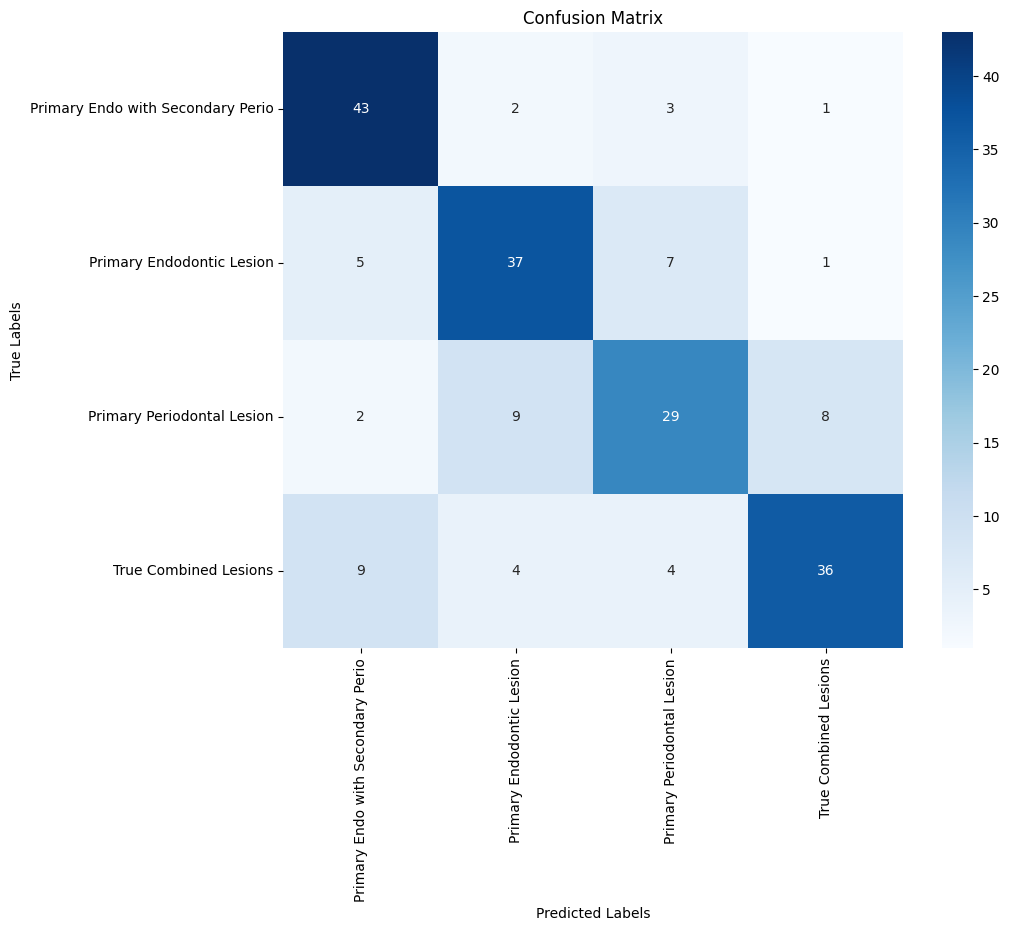

In [ ]:
test_generator1.reset()
predictions = model7.predict(test_generator1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator1.classes
class_labels = list(test_generator1.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

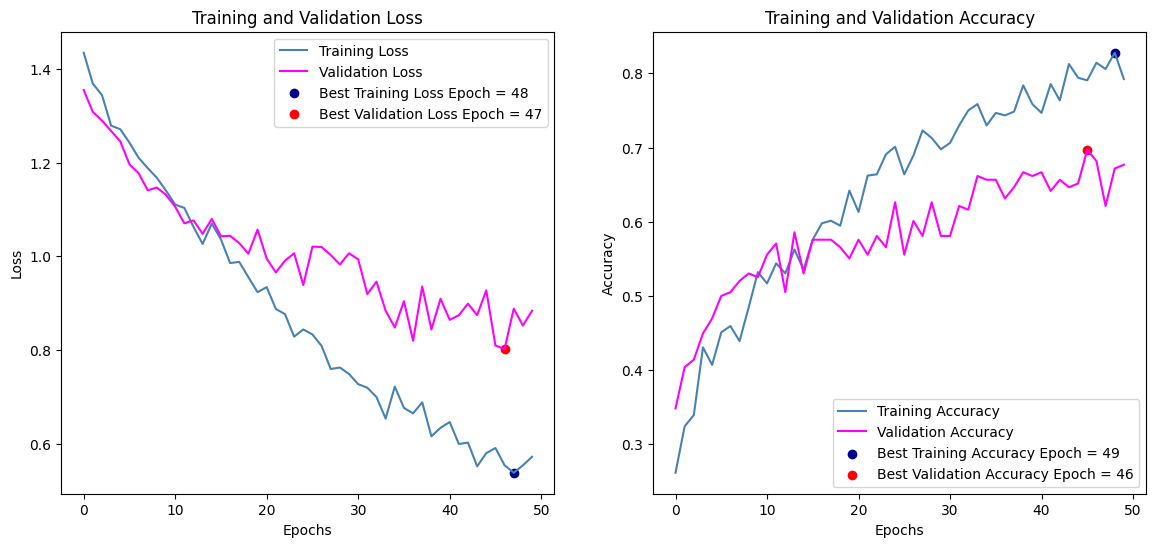

In [ ]:
# Mencari epoch dengan nilai terbaik
best_train_loss_epoch = np.argmin(history7.history['loss'])  # Epoch dengan loss training terbaik
best_val_loss_epoch = np.argmin(history7.history['val_loss'])  # Epoch dengan loss validasi terbaik
best_train_acc_epoch = np.argmax(history7.history['accuracy'])  # Epoch dengan akurasi training terbaik
best_val_acc_epoch = np.argmax(history7.history['val_accuracy'])  # Epoch dengan akurasi validasi terbaik

# Plot loss dan akurasi pada dua subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Training dan Validation Loss
ax1.plot(history7.history['loss'], label='Training Loss', color='steelblue')  # Grafik loss training
ax1.plot(history7.history['val_loss'], label='Validation Loss', color='magenta')  # Grafik loss validasi

# Titik pada epoch dengan Loss terbaik
ax1.scatter(best_train_loss_epoch, history7.history['loss'][best_train_loss_epoch],
            label=f'Best Training Loss Epoch = {best_train_loss_epoch + 1}', color='darkblue')  # Titik terbaik training
ax1.scatter(best_val_loss_epoch, history7.history['val_loss'][best_val_loss_epoch],
            label=f'Best Validation Loss Epoch = {best_val_loss_epoch + 1}', color='red')  # Titik terbaik validasi

ax1.set_title('Training and Validation Loss')  # Judul subplot
ax1.set_xlabel('Epochs')  # Label sumbu X
ax1.set_ylabel('Loss')  # Label sumbu Y
ax1.legend()  # Menampilkan legenda

# Subplot 2: Training dan Validation Accuracy
ax2.plot(history7.history['accuracy'], label='Training Accuracy', color='steelblue')  # Grafik akurasi training
ax2.plot(history7.history['val_accuracy'], label='Validation Accuracy', color='magenta')  # Grafik akurasi validasi

# Titik pada epoch dengan Accuracy terbaik
ax2.scatter(best_train_acc_epoch, history7.history['accuracy'][best_train_acc_epoch],
            label=f'Best Training Accuracy Epoch = {best_train_acc_epoch + 1}', color='darkblue')  # Titik terbaik training
ax2.scatter(best_val_acc_epoch, history7.history['val_accuracy'][best_val_acc_epoch],
            label=f'Best Validation Accuracy Epoch = {best_val_acc_epoch + 1}', color='red')  # Titik terbaik validasi

ax2.set_title('Training and Validation Accuracy')  # Judul subplot
ax2.set_xlabel('Epochs')  # Label sumbu X
ax2.set_ylabel('Accuracy')  # Label sumbu Y
ax2.legend()  # Menampilkan legenda

# Tampilkan grafik
plt.show()

In [ ]:
# Menampilkan precision, recall, f1-score, dan accuracy
precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

Precision: 0.73
Recall: 0.72
F1-Score: 0.72
Accuracy: 0.72


In [ ]:
# Menghitung precision, recall, f1-score, dan accuracy
precision, recall, f1, support = precision_recall_fscore_support(true_classes, predicted_classes, average=None)
weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

# Menampilkan hasil per kelas
print("Per-Class Metrics:")
for i, label in enumerate(class_labels):
    print(f"Class '{label}':")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall: {recall[i]:.2f}")
    print(f"  F1-Score: {f1[i]:.2f}")
    print(f"  Support: {support[i]}")
    print()

# Menampilkan hasil rata-rata tertimbang dan akurasi
print("Overall Metrics:")
print(f"Weighted Precision: {weighted_precision:.2f}")
print(f"Weighted Recall: {weighted_recall:.2f}")
print(f"Weighted F1-Score: {weighted_f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

# Menampilkan hasil dalam bentuk tabel menggunakan pandas (opsional)
import pandas as pd

metrics_df = pd.DataFrame({
    'Class': class_labels,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

metrics_df.loc['Weighted Average'] = ['Overall', weighted_precision, weighted_recall, weighted_f1, sum(support)]

print("\nMetrics Table:")
print(metrics_df)


Per-Class Metrics:
Class 'Primary Endo with Secondary Perio':
  Precision: 0.73
  Recall: 0.88
  F1-Score: 0.80
  Support: 49

Class 'Primary Endodontic Lesion':
  Precision: 0.71
  Recall: 0.74
  F1-Score: 0.73
  Support: 50

Class 'Primary Periodontal Lesion':
  Precision: 0.67
  Recall: 0.60
  F1-Score: 0.64
  Support: 48

Class 'True Combined Lesions':
  Precision: 0.78
  Recall: 0.68
  F1-Score: 0.73
  Support: 53

Overall Metrics:
Weighted Precision: 0.73
Weighted Recall: 0.72
Weighted F1-Score: 0.72
Accuracy: 0.72

Metrics Table:
                                              Class  Precision    Recall  \
0                 Primary Endo with Secondary Perio   0.728814  0.877551   
1                         Primary Endodontic Lesion   0.711538  0.740000   
2                        Primary Periodontal Lesion   0.674419  0.604167   
3                             True Combined Lesions   0.782609  0.679245   
Weighted Average                            Overall   0.725696  0.725000   



# Hyperparameter 3_2

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load ResNet50V2 (alternatively, ResNet101V2 or ResNet152V2)
base_model = resnet_v2.ResNet101V2(
    weights='imagenet',          # Pretrained weights
    include_top=False,           # Exclude fully connected layers
    input_shape=(224, 224, 3)    # Input image size
)

# Freeze all layers except the last few
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Membangun model baru di atas base model VGG16
model8 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Kompilasi model
model8.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model8.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)             │ (None, 7, 7, 2048)          │      42,626,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,840,388 (167.24 MB)

 Trainable params: 2,268,548 (8.65 MB)

 Non-trainable params: 41,571,840 (158.58 MB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
]


In [ ]:
history8 = model8.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.2590 - loss: 1.7983 - val_accuracy: 0.3081 - val_loss: 1.3588 - learning_rate: 1.0000e-04
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 55s 532ms/step - accuracy: 0.2423 - loss: 1.5489 - val_accuracy: 0.4091 - val_loss: 1.3147 - learning_rate: 1.0000e-04
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 563ms/step - accuracy: 0.2840 - loss: 1.5061 - val_accuracy: 0.3939 - val_loss: 1.3014 - learning_rate: 1.0000e-04
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 555ms/step - accuracy: 0.2773 - loss: 1.4504 - val_accuracy: 0.3737 - val_loss: 1.2915 - learning_rate: 1.0000e-04
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 550ms/step - accuracy: 0.3212 - loss: 1.4181 - val_accuracy: 0.4343 - val_loss: 1.2778 - learning_rate: 1.0000e-04
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 541ms/step - accuracy: 0.3733 - loss: 1.3798 - val_accuracy: 0.4545 - val_loss: 1.2587 - learning_rate: 1.0000e-04
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 539ms/step - accuracy: 0.3016 

In [ ]:
# Evaluasi Model
test_loss, test_accuracy = model8.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 619ms/step - accuracy: 0.7364 - loss: 0.7676
Test Accuracy: 68.00%


7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step


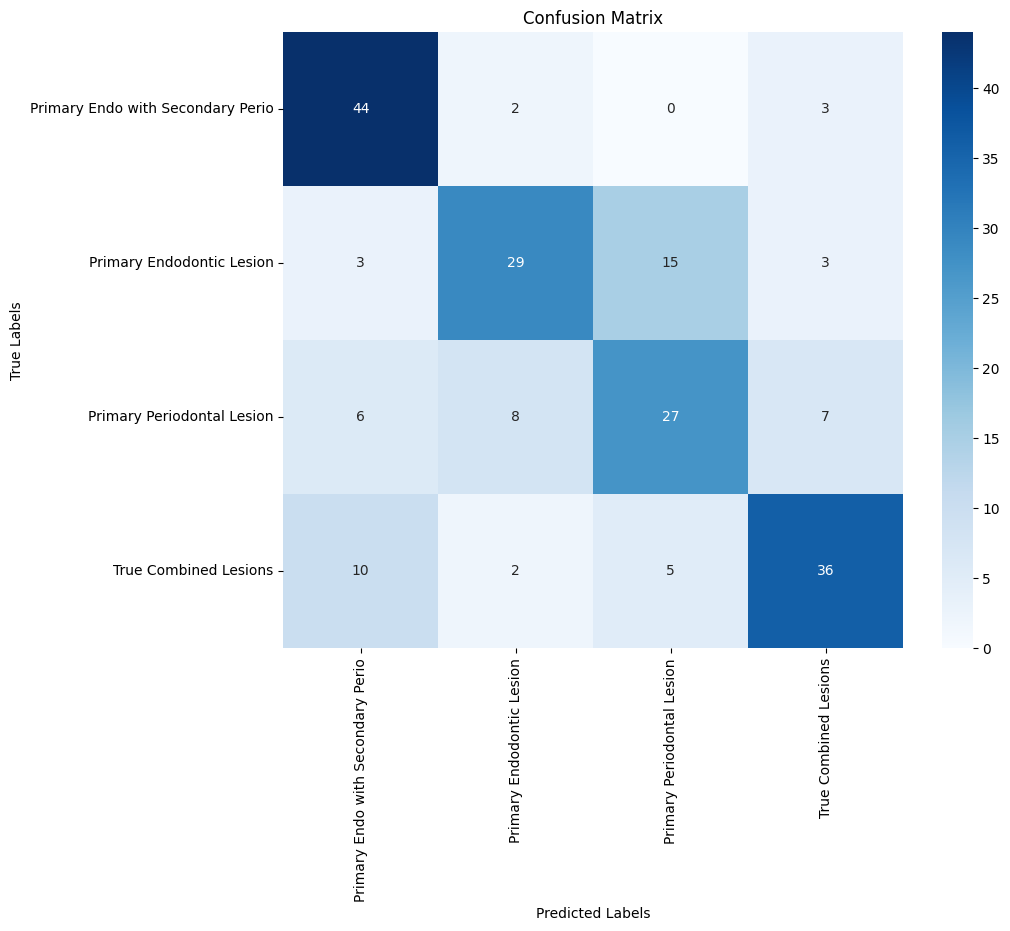

In [ ]:
test_generator.reset()
predictions = model8.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

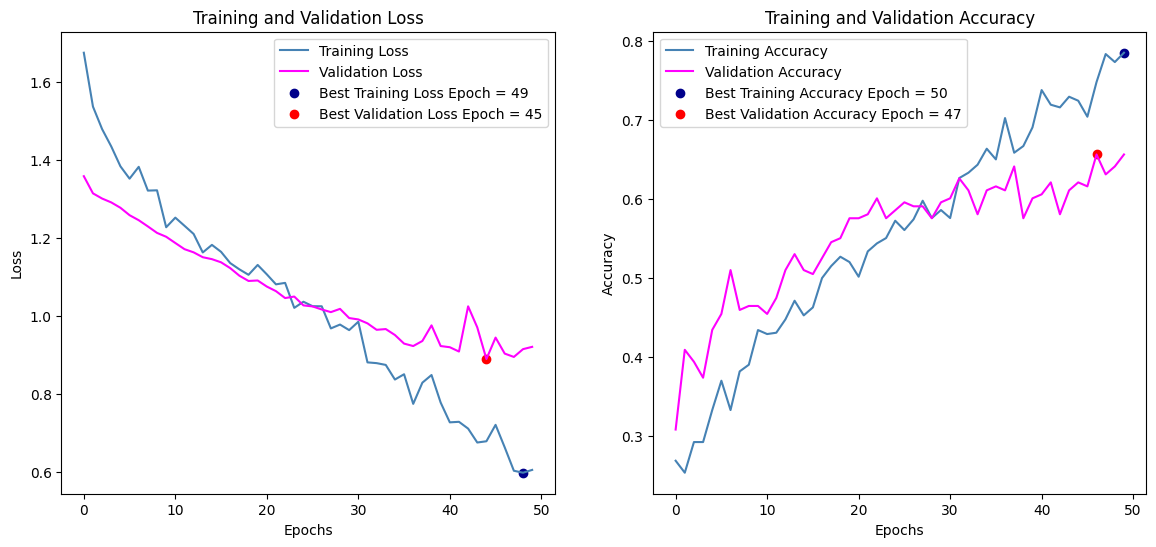

In [ ]:
# Mencari epoch dengan nilai terbaik
best_train_loss_epoch = np.argmin(history8.history['loss'])  # Epoch dengan loss training terbaik
best_val_loss_epoch = np.argmin(history8.history['val_loss'])  # Epoch dengan loss validasi terbaik
best_train_acc_epoch = np.argmax(history8.history['accuracy'])  # Epoch dengan akurasi training terbaik
best_val_acc_epoch = np.argmax(history8.history['val_accuracy'])  # Epoch dengan akurasi validasi terbaik

# Plot loss dan akurasi pada dua subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Training dan Validation Loss
ax1.plot(history8.history['loss'], label='Training Loss', color='steelblue')  # Grafik loss training
ax1.plot(history8.history['val_loss'], label='Validation Loss', color='magenta')  # Grafik loss validasi

# Titik pada epoch dengan Loss terbaik
ax1.scatter(best_train_loss_epoch, history8.history['loss'][best_train_loss_epoch],
            label=f'Best Training Loss Epoch = {best_train_loss_epoch + 1}', color='darkblue')  # Titik terbaik training
ax1.scatter(best_val_loss_epoch, history8.history['val_loss'][best_val_loss_epoch],
            label=f'Best Validation Loss Epoch = {best_val_loss_epoch + 1}', color='red')  # Titik terbaik validasi

ax1.set_title('Training and Validation Loss')  # Judul subplot
ax1.set_xlabel('Epochs')  # Label sumbu X
ax1.set_ylabel('Loss')  # Label sumbu Y
ax1.legend()  # Menampilkan legenda

# Subplot 2: Training dan Validation Accuracy
ax2.plot(history8.history['accuracy'], label='Training Accuracy', color='steelblue')  # Grafik akurasi training
ax2.plot(history8.history['val_accuracy'], label='Validation Accuracy', color='magenta')  # Grafik akurasi validasi

# Titik pada epoch dengan Accuracy terbaik
ax2.scatter(best_train_acc_epoch, history8.history['accuracy'][best_train_acc_epoch],
            label=f'Best Training Accuracy Epoch = {best_train_acc_epoch + 1}', color='darkblue')  # Titik terbaik training
ax2.scatter(best_val_acc_epoch, history8.history['val_accuracy'][best_val_acc_epoch],
            label=f'Best Validation Accuracy Epoch = {best_val_acc_epoch + 1}', color='red')  # Titik terbaik validasi

ax2.set_title('Training and Validation Accuracy')  # Judul subplot
ax2.set_xlabel('Epochs')  # Label sumbu X
ax2.set_ylabel('Accuracy')  # Label sumbu Y
ax2.legend()  # Menampilkan legenda

# Tampilkan grafik
plt.show()

In [ ]:
# Menampilkan precision, recall, f1-score, dan accuracy
precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

Precision: 0.68
Recall: 0.68
F1-Score: 0.68
Accuracy: 0.68


In [ ]:
# Menghitung precision, recall, f1-score, dan accuracy
precision, recall, f1, support = precision_recall_fscore_support(true_classes, predicted_classes, average=None)
weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

# Menampilkan hasil per kelas
print("Per-Class Metrics:")
for i, label in enumerate(class_labels):
    print(f"Class '{label}':")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall: {recall[i]:.2f}")
    print(f"  F1-Score: {f1[i]:.2f}")
    print(f"  Support: {support[i]}")
    print()

# Menampilkan hasil rata-rata tertimbang dan akurasi
print("Overall Metrics:")
print(f"Weighted Precision: {weighted_precision:.2f}")
print(f"Weighted Recall: {weighted_recall:.2f}")
print(f"Weighted F1-Score: {weighted_f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

# Menampilkan hasil dalam bentuk tabel menggunakan pandas (opsional)
import pandas as pd

metrics_df = pd.DataFrame({
    'Class': class_labels,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

metrics_df.loc['Weighted Average'] = ['Overall', weighted_precision, weighted_recall, weighted_f1, sum(support)]

print("\nMetrics Table:")
print(metrics_df)


Per-Class Metrics:
Class 'Primary Endo with Secondary Perio':
  Precision: 0.70
  Recall: 0.90
  F1-Score: 0.79
  Support: 49

Class 'Primary Endodontic Lesion':
  Precision: 0.71
  Recall: 0.58
  F1-Score: 0.64
  Support: 50

Class 'Primary Periodontal Lesion':
  Precision: 0.57
  Recall: 0.56
  F1-Score: 0.57
  Support: 48

Class 'True Combined Lesions':
  Precision: 0.73
  Recall: 0.68
  F1-Score: 0.71
  Support: 53

Overall Metrics:
Weighted Precision: 0.68
Weighted Recall: 0.68
Weighted F1-Score: 0.68
Accuracy: 0.68

Metrics Table:
                                              Class  Precision    Recall  \
0                 Primary Endo with Secondary Perio   0.698413  0.897959   
1                         Primary Endodontic Lesion   0.707317  0.580000   
2                        Primary Periodontal Lesion   0.574468  0.562500   
3                             True Combined Lesions   0.734694  0.679245   
Weighted Average                            Overall   0.680507  0.680000   



# Hyperparameter 3_3



In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load ResNet50V2 (alternatively, ResNet101V2 or ResNet152V2)
base_model = resnet_v2.ResNet101V2(
    weights='imagenet',          # Pretrained weights
    include_top=False,           # Exclude fully connected layers
    input_shape=(224, 224, 3)    # Input image size
)

# Freeze all layers except the last few
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Membangun model baru di atas base model VGG16
model9 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Kompilasi model
model9.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model9.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)             │ (None, 7, 7, 2048)          │      42,626,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,192,516 (164.77 MB)

 Trainable params: 1,620,676 (6.18 MB)

 Non-trainable params: 41,571,840 (158.58 MB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
]


In [ ]:
history9 = model9.fit(
    train_generator1,
    validation_data=validation_generator1,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.2577 - loss: 1.5347 - val_accuracy: 0.3333 - val_loss: 1.3465 - learning_rate: 1.0000e-04
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 53s 676ms/step - accuracy: 0.2848 - loss: 1.4449 - val_accuracy: 0.3081 - val_loss: 1.3527 - learning_rate: 1.0000e-04
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 688ms/step - accuracy: 0.3356 - loss: 1.3801 - val_accuracy: 0.3687 - val_loss: 1.3108 - learning_rate: 1.0000e-04
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 22s 680ms/step - accuracy: 0.2948 - loss: 1.3731 - val_accuracy: 0.4192 - val_loss: 1.2852 - learning_rate: 1.0000e-04
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 693ms/step - accuracy: 0.3405 - loss: 1.3291 - val_accuracy: 0.4747 - val_loss: 1.2672 - learning_rate: 1.0000e-04
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 652ms/step - accuracy: 0.3743 - loss: 1.3193 - val_accuracy: 0.4596 - val_loss: 1.2502 - learning_rate: 1.0000e-04
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 658ms/step - accura

In [ ]:
# Evaluasi Model
test_loss, test_accuracy = model9.evaluate(test_generator1)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 627ms/step - accuracy: 0.8353 - loss: 0.6150
Test Accuracy: 75.50%


7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step


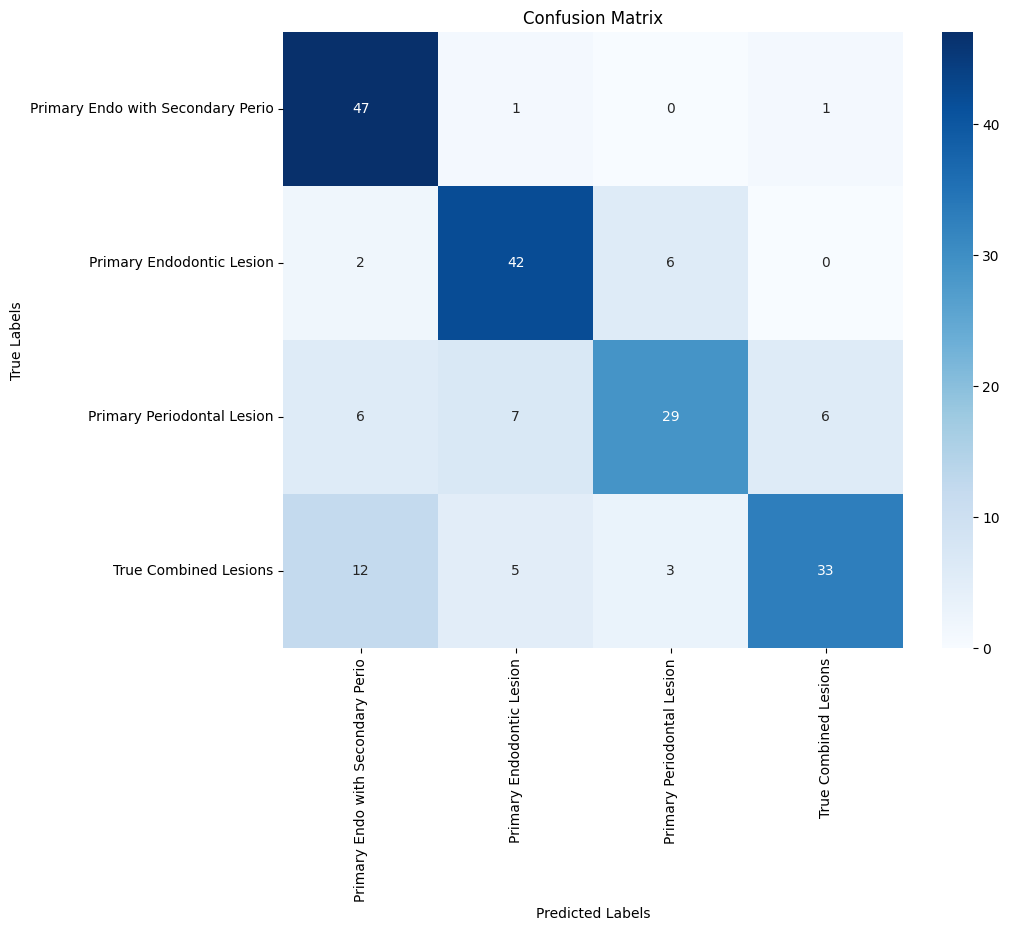

In [ ]:
test_generator1.reset()
predictions = model9.predict(test_generator1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator1.classes
class_labels = list(test_generator1.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

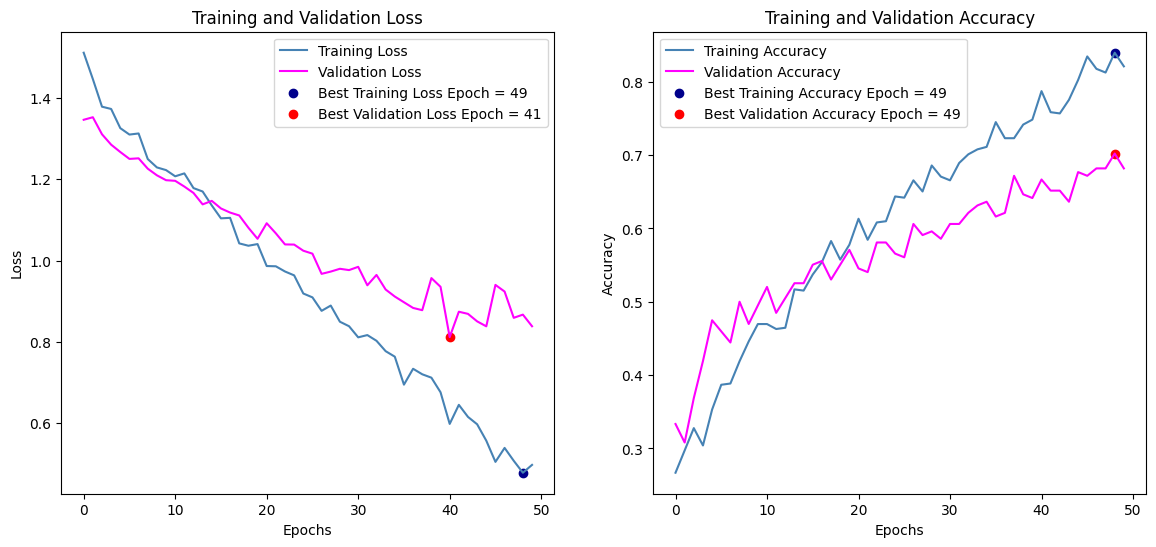

In [ ]:
# Mencari epoch dengan nilai terbaik
best_train_loss_epoch = np.argmin(history9.history['loss'])  # Epoch dengan loss training terbaik
best_val_loss_epoch = np.argmin(history9.history['val_loss'])  # Epoch dengan loss validasi terbaik
best_train_acc_epoch = np.argmax(history9.history['accuracy'])  # Epoch dengan akurasi training terbaik
best_val_acc_epoch = np.argmax(history9.history['val_accuracy'])  # Epoch dengan akurasi validasi terbaik

# Plot loss dan akurasi pada dua subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Training dan Validation Loss
ax1.plot(history9.history['loss'], label='Training Loss', color='steelblue')  # Grafik loss training
ax1.plot(history9.history['val_loss'], label='Validation Loss', color='magenta')  # Grafik loss validasi

# Titik pada epoch dengan Loss terbaik
ax1.scatter(best_train_loss_epoch, history9.history['loss'][best_train_loss_epoch],
            label=f'Best Training Loss Epoch = {best_train_loss_epoch + 1}', color='darkblue')  # Titik terbaik training
ax1.scatter(best_val_loss_epoch, history9.history['val_loss'][best_val_loss_epoch],
            label=f'Best Validation Loss Epoch = {best_val_loss_epoch + 1}', color='red')  # Titik terbaik validasi

ax1.set_title('Training and Validation Loss')  # Judul subplot
ax1.set_xlabel('Epochs')  # Label sumbu X
ax1.set_ylabel('Loss')  # Label sumbu Y
ax1.legend()  # Menampilkan legenda

# Subplot 2: Training dan Validation Accuracy
ax2.plot(history9.history['accuracy'], label='Training Accuracy', color='steelblue')  # Grafik akurasi training
ax2.plot(history9.history['val_accuracy'], label='Validation Accuracy', color='magenta')  # Grafik akurasi validasi

# Titik pada epoch dengan Accuracy terbaik
ax2.scatter(best_train_acc_epoch, history9.history['accuracy'][best_train_acc_epoch],
            label=f'Best Training Accuracy Epoch = {best_train_acc_epoch + 1}', color='darkblue')  # Titik terbaik training
ax2.scatter(best_val_acc_epoch, history9.history['val_accuracy'][best_val_acc_epoch],
            label=f'Best Validation Accuracy Epoch = {best_val_acc_epoch + 1}', color='red')  # Titik terbaik validasi

ax2.set_title('Training and Validation Accuracy')  # Judul subplot
ax2.set_xlabel('Epochs')  # Label sumbu X
ax2.set_ylabel('Accuracy')  # Label sumbu Y
ax2.legend()  # Menampilkan legenda

# Tampilkan grafik
plt.show()

In [ ]:
# Menampilkan precision, recall, f1-score, dan accuracy
precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

Precision: 0.76
Recall: 0.76
F1-Score: 0.75
Accuracy: 0.76


In [ ]:
# Menghitung precision, recall, f1-score, dan accuracy
precision, recall, f1, support = precision_recall_fscore_support(true_classes, predicted_classes, average=None)
weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

# Menampilkan hasil per kelas
print("Per-Class Metrics:")
for i, label in enumerate(class_labels):
    print(f"Class '{label}':")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall: {recall[i]:.2f}")
    print(f"  F1-Score: {f1[i]:.2f}")
    print(f"  Support: {support[i]}")
    print()

# Menampilkan hasil rata-rata tertimbang dan akurasi
print("Overall Metrics:")
print(f"Weighted Precision: {weighted_precision:.2f}")
print(f"Weighted Recall: {weighted_recall:.2f}")
print(f"Weighted F1-Score: {weighted_f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

# Menampilkan hasil dalam bentuk tabel menggunakan pandas (opsional)
import pandas as pd

metrics_df = pd.DataFrame({
    'Class': class_labels,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

metrics_df.loc['Weighted Average'] = ['Overall', weighted_precision, weighted_recall, weighted_f1, sum(support)]

print("\nMetrics Table:")
print(metrics_df)


Per-Class Metrics:
Class 'Primary Endo with Secondary Perio':
  Precision: 0.70
  Recall: 0.96
  F1-Score: 0.81
  Support: 49

Class 'Primary Endodontic Lesion':
  Precision: 0.76
  Recall: 0.84
  F1-Score: 0.80
  Support: 50

Class 'Primary Periodontal Lesion':
  Precision: 0.76
  Recall: 0.60
  F1-Score: 0.67
  Support: 48

Class 'True Combined Lesions':
  Precision: 0.82
  Recall: 0.62
  F1-Score: 0.71
  Support: 53

Overall Metrics:
Weighted Precision: 0.76
Weighted Recall: 0.76
Weighted F1-Score: 0.75
Accuracy: 0.76

Metrics Table:
                                              Class  Precision    Recall  \
0                 Primary Endo with Secondary Perio   0.701493  0.959184   
1                         Primary Endodontic Lesion   0.763636  0.840000   
2                        Primary Periodontal Lesion   0.763158  0.604167   
3                             True Combined Lesions   0.825000  0.622642   
Weighted Average                            Overall   0.764558  0.755000   



In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load ResNet50V2 (alternatively, ResNet101V2 or ResNet152V2)
base_model = resnet_v2.ResNet101V2(
    weights='imagenet',          # Pretrained weights
    include_top=False,           # Exclude fully connected layers
    input_shape=(224, 224, 3)    # Input image size
)

# Freeze all layers except the last few
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Membangun model baru di atas base model VGG16
model8 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Kompilasi model
model8.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model8.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)             │ (None, 7, 7, 2048)          │      42,626,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,840,388 (167.24 MB)

 Trainable params: 2,268,548 (8.65 MB)

 Non-trainable params: 41,571,840 (158.58 MB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
]


In [ ]:
history8 = model8.fit(
    train_generator1,
    validation_data=validation_generator1,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.2265 - loss: 1.7848 - val_accuracy: 0.3535 - val_loss: 1.3569 - learning_rate: 1.0000e-04
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 685ms/step - accuracy: 0.3147 - loss: 1.5290 - val_accuracy: 0.3737 - val_loss: 1.3255 - learning_rate: 1.0000e-04
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 687ms/step - accuracy: 0.3383 - loss: 1.4467 - val_accuracy: 0.3990 - val_loss: 1.3064 - learning_rate: 1.0000e-04
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 686ms/step - accuracy: 0.3623 - loss: 1.3989 - val_accuracy: 0.3990 - val_loss: 1.2749 - learning_rate: 1.0000e-04
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 654ms/step - accuracy: 0.3233 - loss: 1.3553 - val_accuracy: 0.4040 - val_loss: 1.2717 - learning_rate: 1.0000e-04
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 655ms/step - accuracy: 0.3797 - loss: 1.3717 - val_accuracy: 0.4798 - val_loss: 1.2360 - learning_rate: 1.0000e-04
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 676ms/step - accura

In [ ]:
# Evaluasi Model
test_loss, test_accuracy = model8.evaluate(test_generator1)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 766ms/step - accuracy: 0.7507 - loss: 0.7276
Test Accuracy: 68.50%


7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step


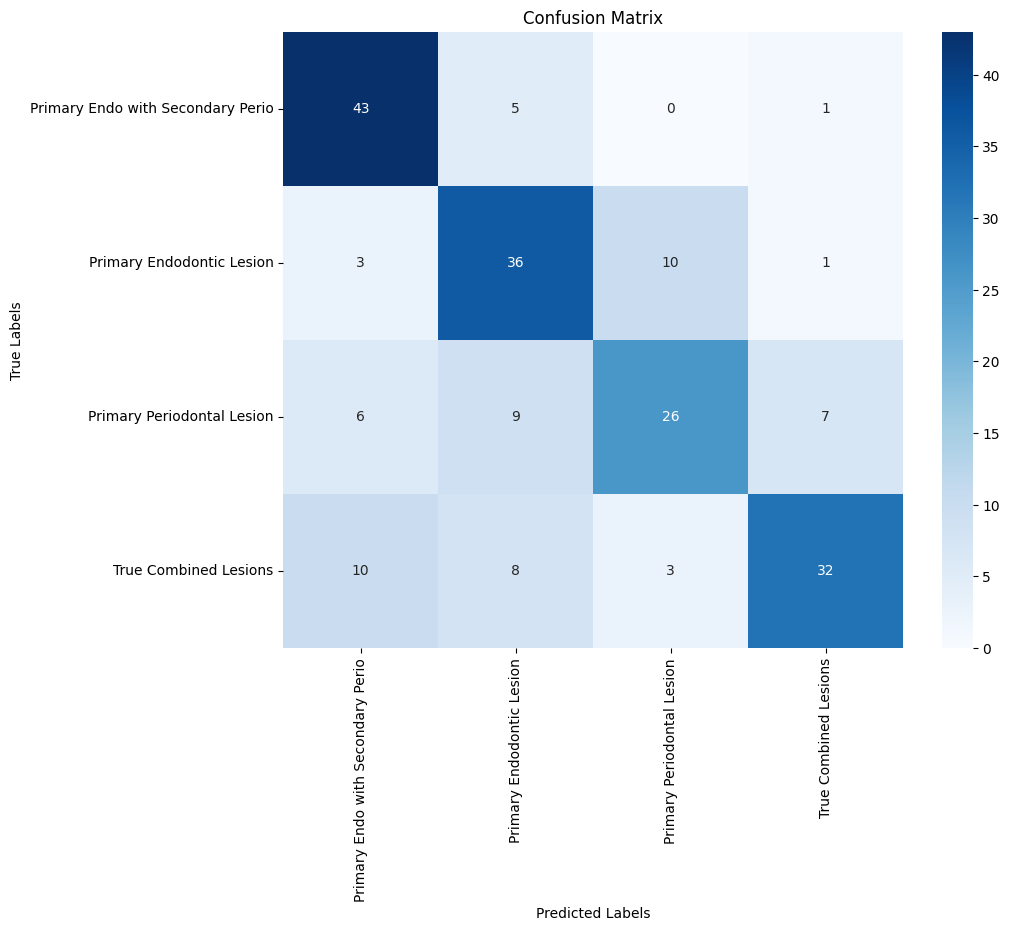

In [ ]:
test_generator1.reset()
predictions = model8.predict(test_generator1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator1.classes
class_labels = list(test_generator1.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

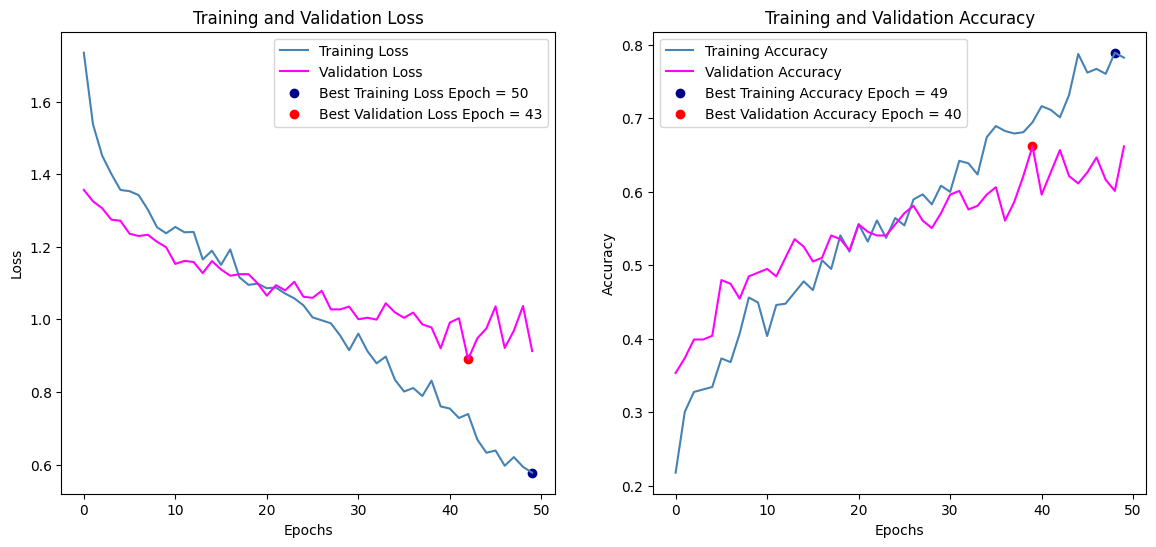

In [ ]:
# Mencari epoch dengan nilai terbaik
best_train_loss_epoch = np.argmin(history8.history['loss'])  # Epoch dengan loss training terbaik
best_val_loss_epoch = np.argmin(history8.history['val_loss'])  # Epoch dengan loss validasi terbaik
best_train_acc_epoch = np.argmax(history8.history['accuracy'])  # Epoch dengan akurasi training terbaik
best_val_acc_epoch = np.argmax(history8.history['val_accuracy'])  # Epoch dengan akurasi validasi terbaik

# Plot loss dan akurasi pada dua subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Training dan Validation Loss
ax1.plot(history8.history['loss'], label='Training Loss', color='steelblue')  # Grafik loss training
ax1.plot(history8.history['val_loss'], label='Validation Loss', color='magenta')  # Grafik loss validasi

# Titik pada epoch dengan Loss terbaik
ax1.scatter(best_train_loss_epoch, history8.history['loss'][best_train_loss_epoch],
            label=f'Best Training Loss Epoch = {best_train_loss_epoch + 1}', color='darkblue')  # Titik terbaik training
ax1.scatter(best_val_loss_epoch, history8.history['val_loss'][best_val_loss_epoch],
            label=f'Best Validation Loss Epoch = {best_val_loss_epoch + 1}', color='red')  # Titik terbaik validasi

ax1.set_title('Training and Validation Loss')  # Judul subplot
ax1.set_xlabel('Epochs')  # Label sumbu X
ax1.set_ylabel('Loss')  # Label sumbu Y
ax1.legend()  # Menampilkan legenda

# Subplot 2: Training dan Validation Accuracy
ax2.plot(history8.history['accuracy'], label='Training Accuracy', color='steelblue')  # Grafik akurasi training
ax2.plot(history8.history['val_accuracy'], label='Validation Accuracy', color='magenta')  # Grafik akurasi validasi

# Titik pada epoch dengan Accuracy terbaik
ax2.scatter(best_train_acc_epoch, history8.history['accuracy'][best_train_acc_epoch],
            label=f'Best Training Accuracy Epoch = {best_train_acc_epoch + 1}', color='darkblue')  # Titik terbaik training
ax2.scatter(best_val_acc_epoch, history8.history['val_accuracy'][best_val_acc_epoch],
            label=f'Best Validation Accuracy Epoch = {best_val_acc_epoch + 1}', color='red')  # Titik terbaik validasi

ax2.set_title('Training and Validation Accuracy')  # Judul subplot
ax2.set_xlabel('Epochs')  # Label sumbu X
ax2.set_ylabel('Accuracy')  # Label sumbu Y
ax2.legend()  # Menampilkan legenda

# Tampilkan grafik
plt.show()

In [ ]:
# Menampilkan precision, recall, f1-score, dan accuracy
precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

Precision: 0.69
Recall: 0.69
F1-Score: 0.68
Accuracy: 0.69


In [ ]:
# Menghitung precision, recall, f1-score, dan accuracy
precision, recall, f1, support = precision_recall_fscore_support(true_classes, predicted_classes, average=None)
weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

# Menampilkan hasil per kelas
print("Per-Class Metrics:")
for i, label in enumerate(class_labels):
    print(f"Class '{label}':")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall: {recall[i]:.2f}")
    print(f"  F1-Score: {f1[i]:.2f}")
    print(f"  Support: {support[i]}")
    print()

# Menampilkan hasil rata-rata tertimbang dan akurasi
print("Overall Metrics:")
print(f"Weighted Precision: {weighted_precision:.2f}")
print(f"Weighted Recall: {weighted_recall:.2f}")
print(f"Weighted F1-Score: {weighted_f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

# Menampilkan hasil dalam bentuk tabel menggunakan pandas (opsional)
import pandas as pd

metrics_df = pd.DataFrame({
    'Class': class_labels,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

metrics_df.loc['Weighted Average'] = ['Overall', weighted_precision, weighted_recall, weighted_f1, sum(support)]

print("\nMetrics Table:")
print(metrics_df)


Per-Class Metrics:
Class 'Primary Endo with Secondary Perio':
  Precision: 0.69
  Recall: 0.88
  F1-Score: 0.77
  Support: 49

Class 'Primary Endodontic Lesion':
  Precision: 0.62
  Recall: 0.72
  F1-Score: 0.67
  Support: 50

Class 'Primary Periodontal Lesion':
  Precision: 0.67
  Recall: 0.54
  F1-Score: 0.60
  Support: 48

Class 'True Combined Lesions':
  Precision: 0.78
  Recall: 0.60
  F1-Score: 0.68
  Support: 53

Overall Metrics:
Weighted Precision: 0.69
Weighted Recall: 0.69
Weighted F1-Score: 0.68
Accuracy: 0.69

Metrics Table:
                                              Class  Precision    Recall  \
0                 Primary Endo with Secondary Perio   0.693548  0.877551   
1                         Primary Endodontic Lesion   0.620690  0.720000   
2                        Primary Periodontal Lesion   0.666667  0.541667   
3                             True Combined Lesions   0.780488  0.603774   
Weighted Average                            Overall   0.691921  0.685000   

